In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/workspaces/my_dissertation')
from visualizations.scripts.drawer import metric_viewer
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import xarray as xr
from tqdm.notebook import tqdm
import glob
from visualizations.scripts.drawer import russia_plots, russia_plots_n
import seaborn as sns
import matplotlib.ticker as ticker
from copy import deepcopy
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib import cm
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

gauges_file = gpd.read_file('../geo_data/great_db/geometry/russia_gauges.gpkg')
ws_file = gpd.read_file('../geo_data/great_db/geometry/russia_ws.gpkg')
ws_file = ws_file.set_index('gauge_id')
ws_file = ws_file[ws_file['new_area'] <= 50000]

def lim_definer(area: float):

    lim_1, lim_2, lim_3, lim_4 = 100, 2000, 10000, 50000

    if area < lim_1:
        return '< 100 $км^2$'
    elif (area >= lim_1) & (area <= lim_2):
        return '100 $км^2$ - 2 000 $км^2$'
    elif (area > lim_2) & (area <= lim_3):
        return '2 000 $км^2$ - 10 000 $км^2$'
    elif (area > lim_3) & (area <= lim_4):
        return '10 000 $км^2$ - 50 000 $км^2$'
    else:
        return '> 50 000 $км^2$'

ws_file['size'] = ws_file.loc[:, 'new_area'].apply(lambda x: lim_definer(x))
ws_file['size'] = pd.Categorical(ws_file['size'],
                                 ['< 100 $км^2$',
                                  '100 $км^2$ - 2 000 $км^2$',
                                  '2 000 $км^2$ - 10 000 $км^2$',
                                  '10 000 $км^2$ - 50 000 $км^2$'])
ws_file = ws_file.loc[tft_era5l.index, :]

basemap_data = gpd.read_file(
    '../geo_data/great_db/geometry/basemap_2023.gpkg')
ugms_shp = gpd.read_file(
    '../geo_data/great_db/geometry/ugms.shp')[['name1', 'geometry']]
# Update geometrty in UGMS based on available gage stations
# sib
srednesib_limit = gpd.read_file(
    '../geo_data/great_db/geometry/srednesib_lim.gpkg')
ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = ['Среднесибирское, ограниченное', ugms_shp.loc[17,
                                                                                                      'geometry'].intersection(srednesib_limit.loc[0, 'geometry'])]
# yakutsk
yakutsk_limit = gpd.read_file(
    '../geo_data/great_db/geometry/yakut_lim.gpkg')
ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = ['Якутское, ограниченное', ugms_shp.loc[23,
                                                                                               'geometry'].intersection(yakutsk_limit.loc[0, 'geometry'])]
# chukotka
chukotka_limit = gpd.read_file(
    '../geo_data/great_db/geometry/chukot_limit.gpkg')
ugms_shp.loc[len(ugms_shp)+1, ['name1', 'geometry']] = [
    'Чукотское, ограниченное', ugms_shp.loc[22, 'geometry'].intersection(
        chukotka_limit.loc[0, 'geometry'])]
ugms_shp = ugms_shp.reset_index(drop=True)
# fixed umgs shapes 
ugms_shp = ugms_shp.reindex([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                             12, 13, 14, 15, 16, 25, 18, 19, 20, 21,
                             27, 26, 24, 17, 23, 22])
ugms_shp = ugms_shp.reset_index(drop=True)

In [89]:
wholeRussiaEval = np.load('./verif_metrics_20210930.npy',
                          allow_pickle=True).item()

forecastHindcast = np.load('./oper_hindcasts_and_forecasts.npy',
                           allow_pickle=True).item()

actualObs = np.load('./obs_and_qfh_stat_and_hist_hindcasts.npy',
                    allow_pickle=True).item()

In [100]:
ref_df = pd.DataFrame()
for i, (gauge, metrics) in enumerate(wholeRussiaEval['HBV_NSE']['0'].items()):
    ref_df.loc[i, 'gauge_id'] = str(gauge)
    ref_df.loc[i, 'NSE'] = metrics['NSE']

In [101]:
ref_df.dropna().reset_index(drop=True).to_csv('./tables/DELETE_NSE_HBV.csv',
                                              index=False)

### Best meteo input

In [3]:
def get_r2(df,
           frequency: str,
           prcp_col: str,
           hydro_col: str = 'q_mm_day'):
    df = df.groupby(pd.Grouper(freq=frequency)).sum()
    df = pd.concat([df[prcp_col], df[hydro_col]], axis=1).dropna()
    return pearsonr(x=df[hydro_col], y=df[prcp_col])


res_df = list()
for file in tqdm(glob.glob('../geo_data/great_db/nc_all_q/*.nc')):
    
    gauge_id = file.split('/')[-1][:-3]
    test_df = xr.open_dataset(file)
    test_df = test_df.to_dataframe()[['q_cms_s', 'q_mm_day', 'lvl_sm',
                                      'prcp_e5', 'prcp_e5l',
                                      'prcp_gpcp', 'prcp_imerg',
                                      'prcp_mswep']]

    res_df.append(pd.DataFrame({prcp_col: get_r2(df=test_df,
                                frequency='7D',
                                prcp_col=prcp_col,
                                hydro_col='q_mm_day')[0]
    for prcp_col in ['prcp_e5', 'prcp_e5l',
                     'prcp_gpcp', 'prcp_imerg',
                     'prcp_mswep']},
                               index=[gauge_id]))
res_df = pd.concat(res_df)
res_df.index.name = 'gauge_id'
geom_r2 = gauges_file.set_index('gauge_id').join(res_df).dropna()

A Jupyter Widget

/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/conda/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient 

In [4]:
def r2_descriptor(r2_df: pd.DataFrame,
                  prcp_col: str,
                  day_range: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Сумма за дней:'] = day_range
    res_df.loc[0, 'Источник реанализа'] = prcp_col
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(r2_df):.0f}'
    
    nse_max = r2_df[prcp_col].max()
    res_df.loc[0, 'Максимальная корреляция'] = f'{nse_max:.2f}'
    
    nse_median = r2_df[prcp_col].median()
    res_df.loc[0, 'Медианная корреляция'] = f'{nse_median:.2f}'
    
    nse_mean = r2_df[prcp_col].mean()
    res_df.loc[0, 'Средняя корреляция'] = f'{nse_mean:.2f}'
    
    nse_min = r2_df[prcp_col].min()
    res_df.loc[0, 'Минимальная корреляция'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (r2_df[prcp_col] < 0).sum()
    res_df.loc[0, 'Корреляция < 0'] = f'{nse_less_t_z:.0f}'
        
    return res_df

### Meteo Correlation table

In [6]:
r2_1d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_1d.append(r2_descriptor(r2_df=geom_r2, prcp_col=met_col, day_range='1 день'))
r2_1d_df = pd.concat(r2_1d)
r2_7d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_7d.append(r2_descriptor(r2_df=geom_r2, prcp_col=met_col, day_range='7 дней'))
r2_7d_df = pd.concat(r2_7d)
r2_30d = list()
for met_col in ['prcp_e5', 'prcp_e5l', 'prcp_gpcp', 'prcp_imerg', 'prcp_mswep']:
    r2_30d.append(r2_descriptor(r2_df=geom_r2, prcp_col=met_col, day_range='30 дней'))
r2_30d_df = pd.concat(r2_30d)
res_df = pd.concat([r2_1d_df, r2_7d_df, r2_30d_df]).reset_index(drop=True)
test_df = res_df.set_index(['Сумма за дней:', 'Источник реанализа'],
                           append=False)
test_df.to_csv('./results/r2_meteo.csv')

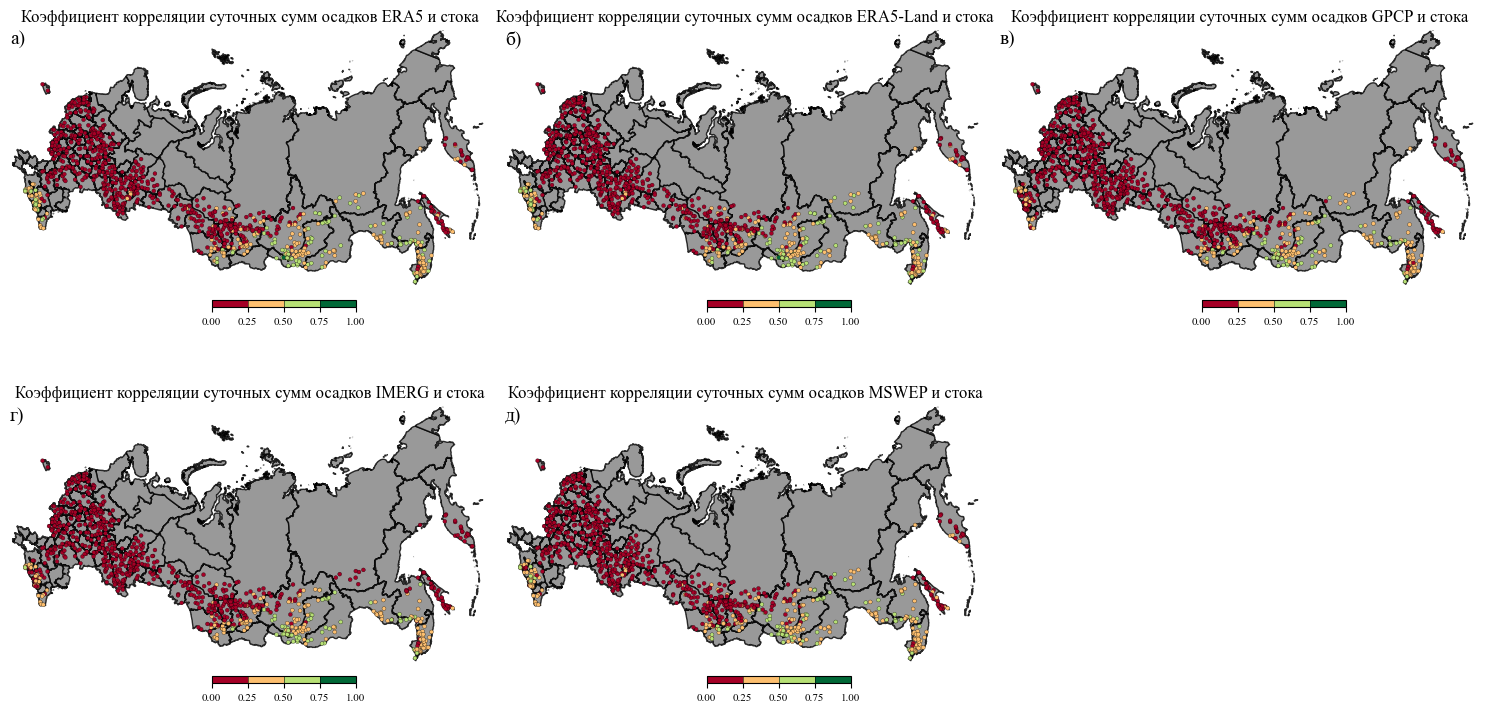

In [11]:
r2_plots = russia_plots_n(
    gdf_to_plot=geom_r2,
    basemap_data=basemap_data,
    cmap_name='RdYlGn',
    figsize=(15, 8),
    label_list=['а)', 'б)', 'в)', 'г)', 'д)'],
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                      'prcp_gpcp', 'prcp_imerg',
                      'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции суточных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции суточных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции суточных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции суточных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции суточных сумм осадков MSWEP и стока'])
r2_plots.savefig('./images/r2_plots_1d.png',
                 dpi=650, bbox_inches='tight')

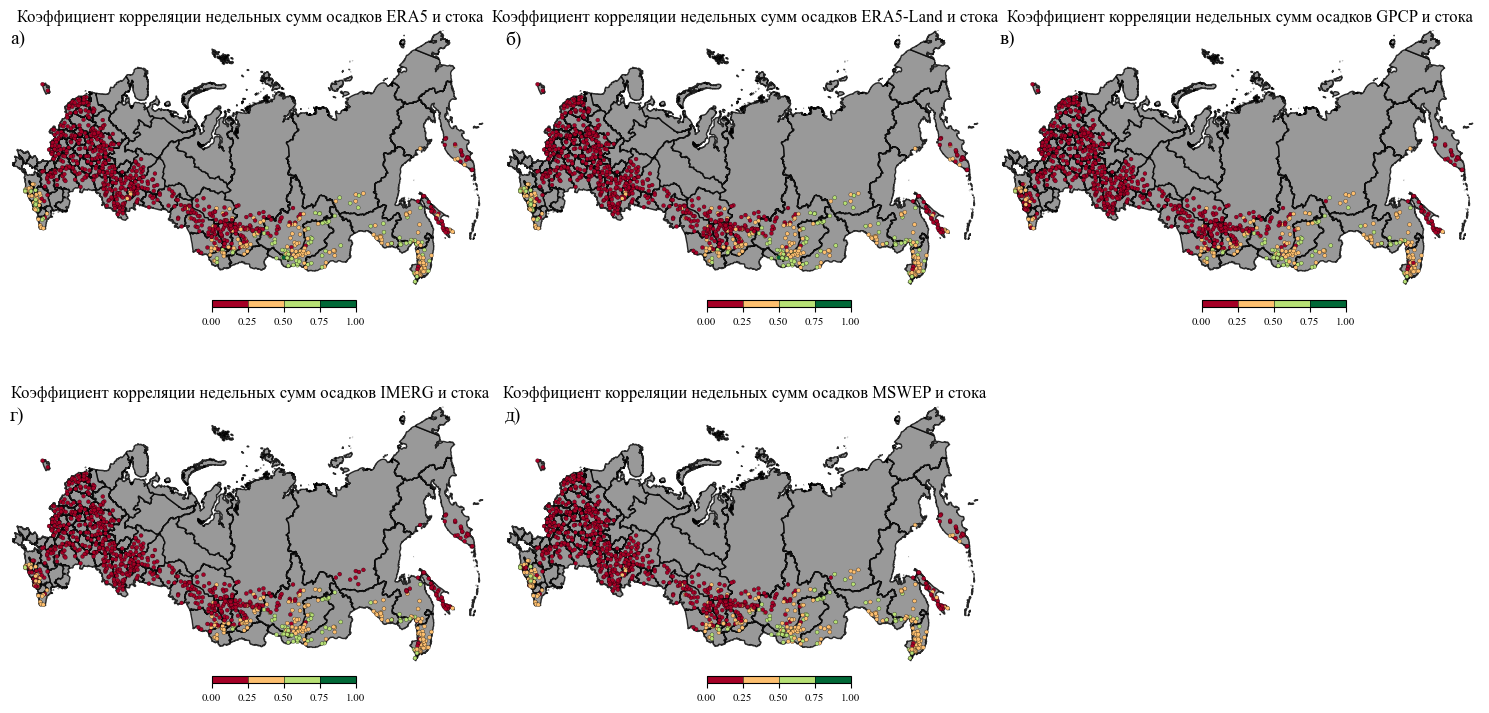

In [12]:
r2_plots_7d = russia_plots_n(
    gdf_to_plot=geom_r2,
    basemap_data=basemap_data,
    figsize=(15, 8),
    label_list=['а)', 'б)', 'в)', 'г)', 'д)'],
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                                 'prcp_gpcp', 'prcp_imerg',
                                 'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции недельных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции недельных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции недельных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции недельных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции недельных сумм осадков MSWEP и стока'])
r2_plots_7d.savefig('./images/r2_plots_7d.png',
                    dpi=650, bbox_inches='tight')

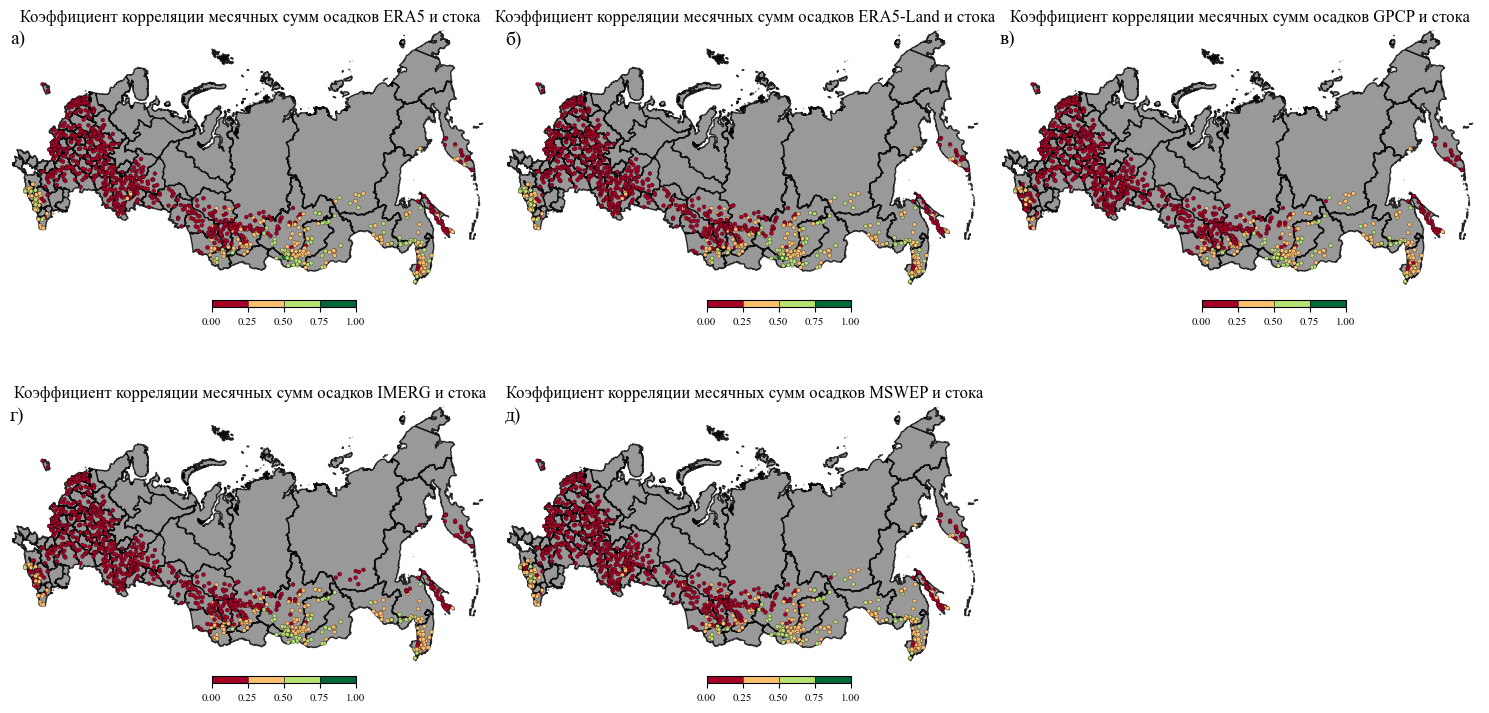

In [13]:
r2_plots_30d = russia_plots_n(
    gdf_to_plot=geom_r2,
    basemap_data=basemap_data,
    figsize=(15, 8),
    label_list=['а)', 'б)', 'в)', 'г)', 'д)'],
    nrows=2,
    ncols=3,
    columns_from_gdf=['prcp_e5', 'prcp_e5l',
                      'prcp_gpcp', 'prcp_imerg',
                      'prcp_mswep'],
    with_histogram=False, title_text=['Коэффициент корреляции месячных сумм осадков ERA5 и стока',
                                      'Коэффициент корреляции месячных сумм осадков ERA5-Land и стока',
                                      'Коэффициент корреляции месячных сумм осадков GPCP и стока',
                                      'Коэффициент корреляции месячных сумм осадков IMERG и стока',
                                      'Коэффициент корреляции месячных сумм осадков MSWEP и стока'])
r2_plots_30d.savefig('./images/r2_plots_30d.png',
                     dpi=650, bbox_inches='tight')

### Different meteo input

In [5]:
# lstm era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm era5
lstm_era5, nse_era5 = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5_SmallMedium_1205_112433/test/model_epoch021/test_metrics.csv',
                                    metric_col='NSE',
                                    gauges_file=gauges_file)
# lstm gpcp
lstm_gpcp, nse_gpcp = metric_viewer(metric_csv='../test_meteo_input/runs_static/gpcp_SmallMedium_1205_054740/test/model_epoch030/test_metrics.csv',
                                         metric_col='NSE',
                                         gauges_file=gauges_file)
# lstm imerg
lstm_imerg, nse_imerg = metric_viewer(metric_csv='../test_meteo_input/runs_static/imerg_SmallMedium_1205_085602/test/model_epoch030/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# lstm mswep
lstm_mswep, nse_mswep = metric_viewer(metric_csv='../test_meteo_input/runs_static/mswep_static_SmallMedium_0205_153244/test/model_epoch021/test_metrics.csv',
                                          metric_col='NSE',
                                          gauges_file=gauges_file)
# lstm no static
lstm_no_static, nse_no_static = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                              metric_col='NSE',
                                              gauges_file=gauges_file)
# file for table
nse_file = gpd.GeoDataFrame(geometry=lstm_era5['geometry'])
nse_file.index = lstm_era5.index
nse_file[['name_ru', 'name_en']] = lstm_era5[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5l['NSE']
nse_file['NSE_era5'] = lstm_era5['NSE']
nse_file['NSE_gpcp'] = lstm_gpcp['NSE']
nse_file['NSE_imerg'] = lstm_imerg['NSE']
nse_file['NSE_mswep'] = lstm_mswep['NSE']
nse_file['NSE_no_static'] = lstm_no_static['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
          'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = nse_file[
              ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
               'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].clip(lower=0)
# give ugms some shine
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = ugms_part[['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                                                              'NSE_imerg', 'NSE_mswep', 'NSE_no_static']].median()
ugms_shp.loc[[25, 26, 27], ['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                     'NSE_imerg', 'NSE_mswep', 'NSE_no_static']] = np.NaN

A Jupyter Widget

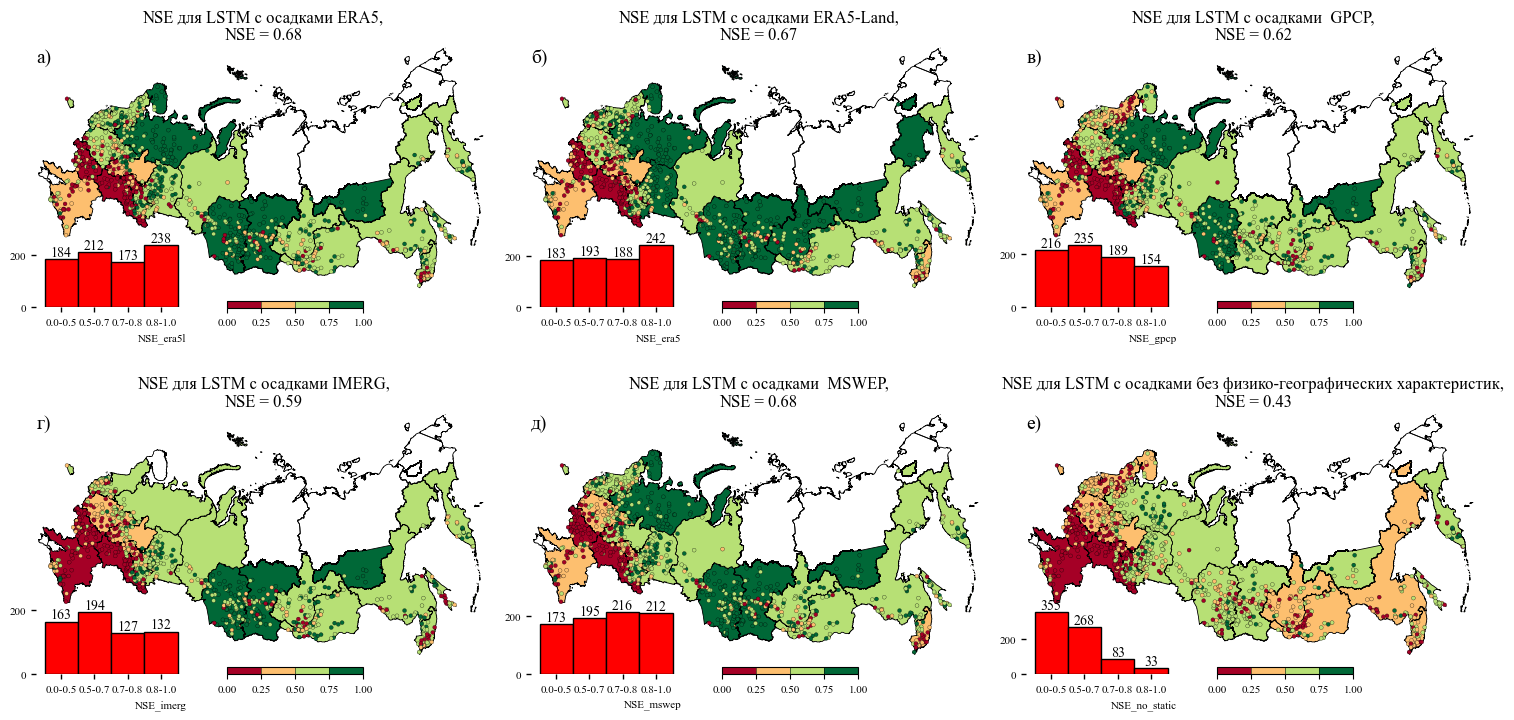

In [86]:
meteo_nse = russia_plots_n(gdf_to_plot=nse_file,
                           basemap_data=basemap_data,
                           figsize=(15, 8),
                           nrows=2,
                           ncols=3,
                           label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
                           columns_from_gdf=['NSE_era5l', 'NSE_era5', 'NSE_gpcp',
                                             'NSE_imerg', 'NSE_mswep', 'NSE_no_static'],
                           with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5,\nNSE = {nse_era5:.2f}',
                                                            f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                            f'NSE для LSTM с осадками  GPCP,\nNSE = {nse_gpcp:.2f}',
                                                            f'NSE для LSTM с осадками IMERG,\nNSE = {nse_imerg:.2f}',
                                                            f'NSE для LSTM с осадками  MSWEP,\nNSE = {nse_mswep:.2f}',
                                                            f'NSE для LSTM с осадками без физико-географических характеристик,\nNSE = {nse_no_static:.2f}'],
                           ugms=True, ugms_gdf=ugms_shp)
meteo_nse.savefig('./images/meteo_nse.png',
                  dpi=1000, bbox_inches='tight')

### Spatial distribution of NSE quality

In [3]:
# tft era5l
lstm_era5l, nse_era5l = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                      metric_col='NSE',
                                      gauges_file=gauges_file)
# tft single era5l
tft_era5l, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# tft single era5l
tft_all_era5l, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# hbv era5l
hbv_era5l, nse_hbv = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j era5l
gr4j_era5l, nse_gr4j = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# rfr era5l
rfr_era5l, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)


In [ ]:
nse_file = gpd.GeoDataFrame(geometry=lstm_era5['geometry'])
nse_file.index = lstm_era5.index
nse_file[['name_ru', 'name_en']] = lstm_era5[['name_ru', 'name_en']]
nse_file['NSE_era5l'] = lstm_era5['NSE']
nse_file['NSE_TFT'] = tft_era5l['NSE']
nse_file['NSE_TFT_all'] = tft_all_era5l['NSE']
nse_file['NSE_hbv'] = hbv_ayzel['NSE']
nse_file['NSE_gr4j'] = gr4j_ayzel['NSE']
nse_file['NSE_rfr'] = rfr_era5l['NSE']
# get rid of imerg errors
# nse_file = nse_file.replace(np.NaN, 0)
nse_file[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
          'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = nse_file[
              ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
               'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].clip(lower=0)

for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = nse_file.loc[[geom.intersects(gage_point)
                              for gage_point in nse_file['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = ugms_part[['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                                                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']].median()
ugms_shp.loc[[25, 26, 27], ['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                     'NSE_hbv', 'NSE_gr4j', 'NSE_rfr']] = np.NaN

In [14]:
tft_era5l

name_ru                            name_en   
gauge_id                                                                        
49014        р.Корпи-Йоки - пос.Пяозерский     r.Korpi-Joki - pos.Pjaozerskij  \
49047               р.Судно - с.Вокнаволок             r.Sudno - s.Voknavolok   
49052                р.Ухта - пгт Калевала              r.Uhta - pgt Kalevala   
49058            р.Чирко-Кемь - с.Юшкозеро       r.Chirko-Kem' - s.Jushkozero   
49070                  р.Шуя - с.Шуерецкое            r.Shuja - s.Shueretskoe   
...                                    ...                                ...   
5664       р.Левый Ул - пос.Многовершинный   r.Levyj Ul - pos.Mnogovershinnyj   
49053          р.Норви-Йоки - пгт Калевала        r.Norvi-Joki - pgt Kalevala   
2107               р.Половинка - г.Елизово            r.Polovinka - g.Elizovo   
2106      р.Половинка - в 13.7 км от устья  r.Polovinka - v 13.7 km ot ust'ja   
7176               р.Слюдянка - г.Слюдянка        r.Sljudjanka - g.Sljudjanka   

                            geometry       NSE    day      static    encoder   
gauge_id                                                                       
49014      POINT (31.05794 65.77917)  0.949277  294.0  inu_pc_ult   prcp_e5l  \
49047      POINT (30.50502 64.95504)  0.951980    1.0  ele_mt_sav   q_mm_day   
49052      POINT (31.14297 65.21779)  0.732684    1.0  ire_pc_sse   prcp_e5l   
49058      POINT (32.11508 64.75309)  0.975160   74.0  ele_mt_sav   q_mm_day   
49070      POINT (34.71204 64.74240)  0.744663   24.0  lkv_mc_usu   q_mm_day   
...                              ...       ...    ...         ...        ...   
5664      POINT (139.86442 53.61337)  0.843053   62.0  sgr_dk_sav   prcp_e5l   
49053      POINT (31.22690 65.19361)  0.953800  365.0  lkv_mc_usu  t_max_e5l   
2107      POINT (158.36421 53.18661)  0.927761    1.0  lka_pc_use   q_mm_day   
2106      POINT (158.21890 53.16076)  0.838575  202.0  sgr_dk_sav   q_mm_day   
7176      POINT (103.69834 51.64244)  0.193418    1.0  ire_pc_sse   q_mm_day   

            decoder  
gauge_id             
49014      prcp_e5l  
49047      prcp_e5l  
49052     t_max_e5l  
49058     t_max_e5l  
49070     t_max_e5l  
...             ...  
5664       prcp_e5l  
49053     t_max_e5l  
2107      t_min_e5l  
2106      t_min_e5l  
7176       prcp_e5l  

[909 rows x 8 columns]

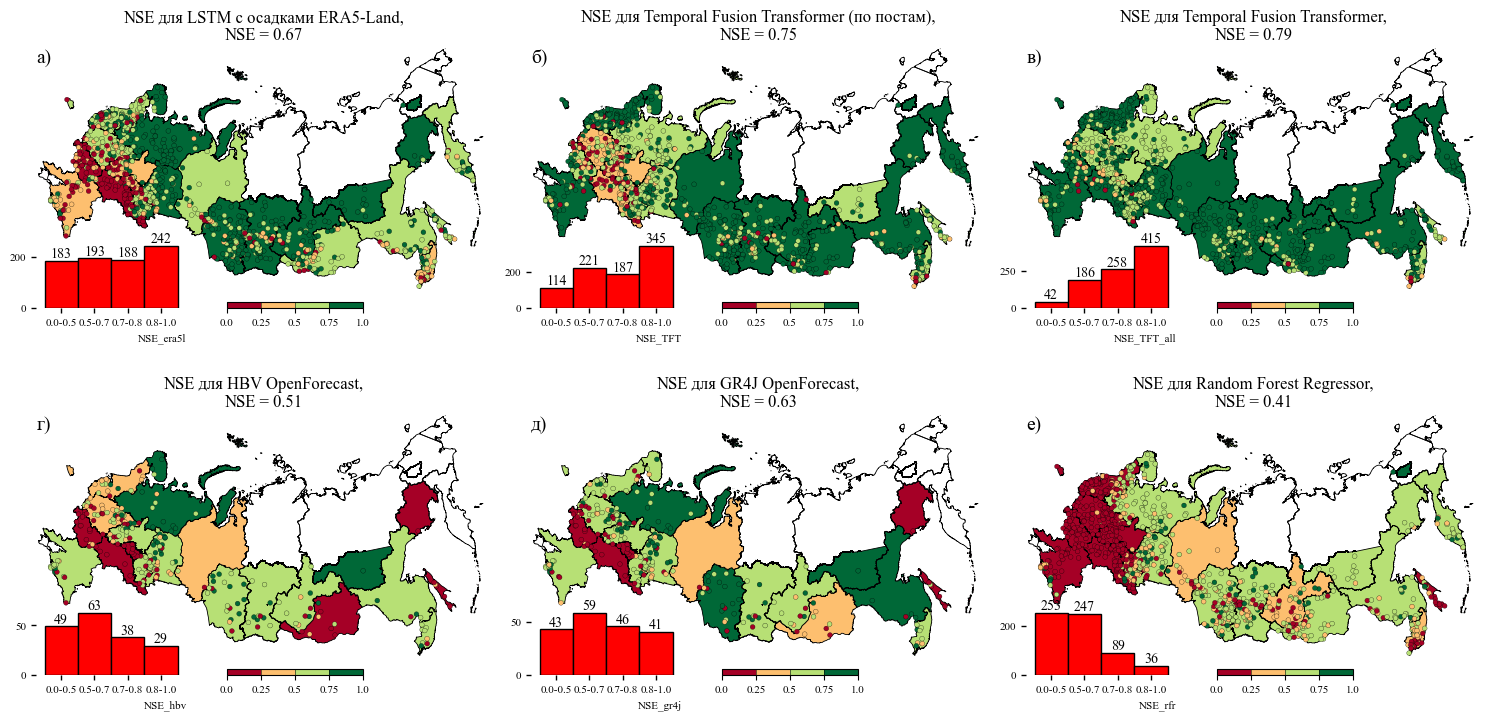

In [10]:
differ_models = russia_plots_n(gdf_to_plot=nse_file,
               basemap_data=basemap_data,
               figsize=(15, 8),
               nrows=2,
               ncols=3,
               columns_from_gdf=['NSE_era5l', 'NSE_TFT', 'NSE_TFT_all',
                                 'NSE_hbv', 'NSE_gr4j', 'NSE_rfr'],
               label_list=['а)', 'б)', 'в)', 'г)', 'д)', 'е)'],
               with_histogram=True, title_text=[f'NSE для LSTM с осадками ERA5-Land,\nNSE = {nse_era5l:.2f}',
                                                f'NSE для Temporal Fusion Transformer (по постам),\nNSE = {nse_tft:.2f}',
                                                f'NSE для Temporal Fusion Transformer,\nNSE = {nse_tft_all:.2f}',
                                                f'NSE для HBV OpenForecast,\nNSE = {nse_hbv_ayzel:.2f}',
                                                f'NSE для GR4J OpenForecast,\nNSE = {nse_gr4j__ayzel:.2f}',
                                                f'NSE для Random Forest Regressor,\nNSE = {nse_rfr:.2f}'],
               ugms=True, ugms_gdf=ugms_shp);
differ_models.savefig('./images/differ_models.png',
                      dpi=1500, bbox_inches='tight')

### Blind forecast

In [101]:
# lstm blind
lstm_blind, nse_lstm_blind = metric_viewer(metric_csv='../test_meteo_input/runs_blind/era5L_static_CellsBlind_2004_130807/test/model_epoch024/test_metrics.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
# tft blind
tft_blind, nse_tft_blind = metric_viewer(metric_csv='../forecast/result/blind_forecast.csv',
                                           metric_col='NSE',
                                           gauges_file=gauges_file)
lstm_blind = lstm_blind[lstm_blind.index.isin(tft_blind.index)]


blind_gdf = gpd.GeoDataFrame(geometry=lstm_blind['geometry'])

blind_gdf['NSE_blind_tft'] = tft_blind['NSE']
blind_gdf['NSE_blind_lstm'] = lstm_blind['NSE']
blind_gdf.to_csv('./tables/partial_gages.csv')

for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = blind_gdf.loc[[geom.intersects(gage_point)
                              for gage_point in blind_gdf['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['NSE_blind_tft', 'NSE_blind_lstm']] = ugms_part[['NSE_blind_tft', 'NSE_blind_lstm']].median()
ugms_shp.loc[[25, 26, 27], ['NSE_blind_tft', 'NSE_blind_lstm']] = np.NaN

A Jupyter Widget

In [109]:
gr4j_ayzel

name_ru   
gauge_id                                         
49058                р.Чирко-Кемь - с.Юшкозеро  \
49070                      р.Шуя - с.Шуерецкое   
49123                 р.Сума - с.Сумский Посад   
71085                 р.Лотта - пор.Каллокоски   
71104     р.Кола - 1429-ый км Октябрьской ж.д.   
...                                        ...   
73110               р.Западная Двина - г.Велиж   
73186              р.Торопа - ст.Старая Торопа   
74413                 р.Преголя - г.Черняховск   
74416                  р.Преголя - г.Гвардейск   
82033         р.Западный Дагомыс - пос.Дагомыс   

                                         name_en                   geometry   
gauge_id                                                                      
49058               r.Chirko-Kem' - s.Jushkozero  POINT (32.11508 64.75309)  \
49070                    r.Shuja - s.Shueretskoe  POINT (34.71204 64.74240)   
49123                   r.Suma - s.Sumskij Posad  POINT (35.41194 64.24372)   
71085                   r.Lotta - por.Kallokoski  POINT (28.93065 68.54590)   
71104     r.Kola - 1429-yj km Oktjabr'skoj zh.d.  POINT (33.09036 68.83594)   
...                                          ...                        ...   
73110               r.Zapadnaja Dvina - g.Velizh  POINT (31.18604 55.60271)   
73186               r.Toropa - st.Staraja Toropa  POINT (31.69424 56.28023)   
74413                r.Pregolja - g.Chernjahovsk  POINT (21.78917 54.64810)   
74416                   r.Pregolja - g.Gvardejsk  POINT (21.09274 54.64181)   
82033           r.Zapadnyj Dagomys - pos.Dagomys  POINT (39.65304 43.66216)   

                 NSE  
gauge_id              
49058      -1.757978  
49070       0.178350  
49123       0.453076  
71085       0.856896  
71104       0.829837  
...              ...  
73110       0.661066  
73186       0.244121  
74413       0.488923  
74416       0.022534  
82033    -464.623325  

[393 rows x 4 columns]

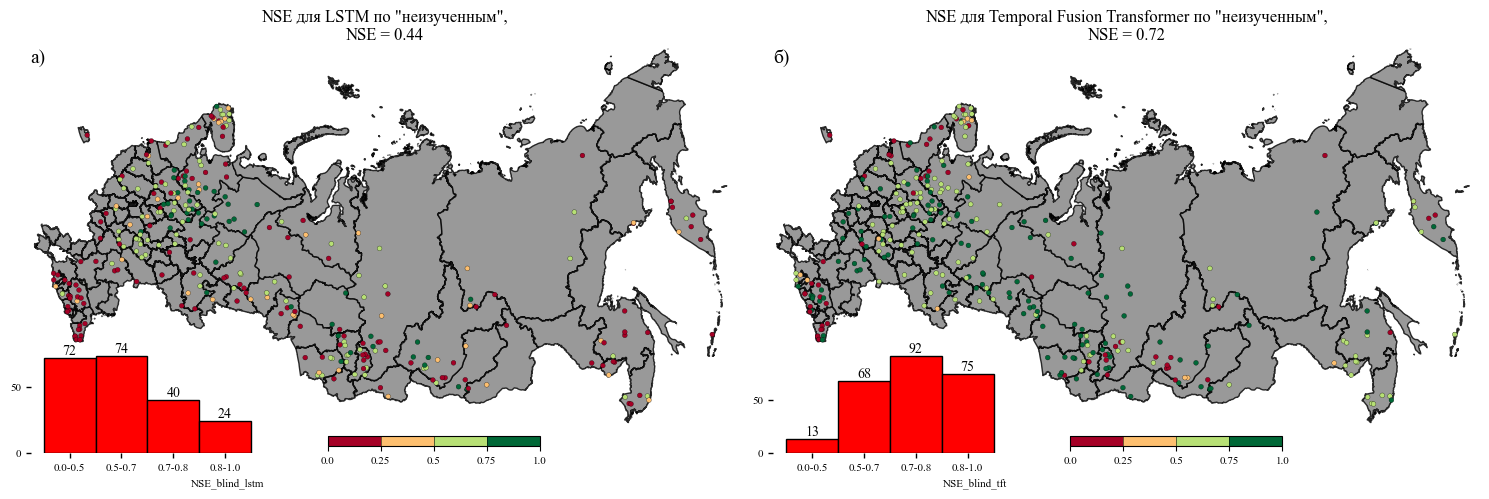

In [114]:
blind_plots = russia_plots_n(
    gdf_to_plot=blind_gdf,
    basemap_data=basemap_data,
    figsize=(15, 8),
    label_list=['а)', 'б)'],
    nrows=1,
    ncols=2,
    columns_from_gdf=['NSE_blind_lstm', 'NSE_blind_tft'],
    with_histogram=True,
    title_text=[f'NSE для LSTM по "неизученным",\nNSE = {nse_lstm_blind:.2f}',
                f'NSE для Temporal Fusion Transformer по "неизученным",\nNSE = {nse_tft_blind:.2f}'])
blind_plots.savefig('./images/blind_forecast.png',
                    dpi=1000, bbox_inches='tight')

### CDF for model runs

In [12]:
# random forest regressor
rfr_run, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# hbv
hbv_ayzel, nse_hbv_ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE_HBV.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
gr4j_ayzel, nse_gr4j__ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# hbv
my_hbv, nse_hbv_my = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
my_gr4j, nse_gr4j_my = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# tft (by gauge)
tft_run, nse_tft_single = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                        metric_col='NSE',
                                        gauges_file=gauges_file)
# tft (all together)
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)

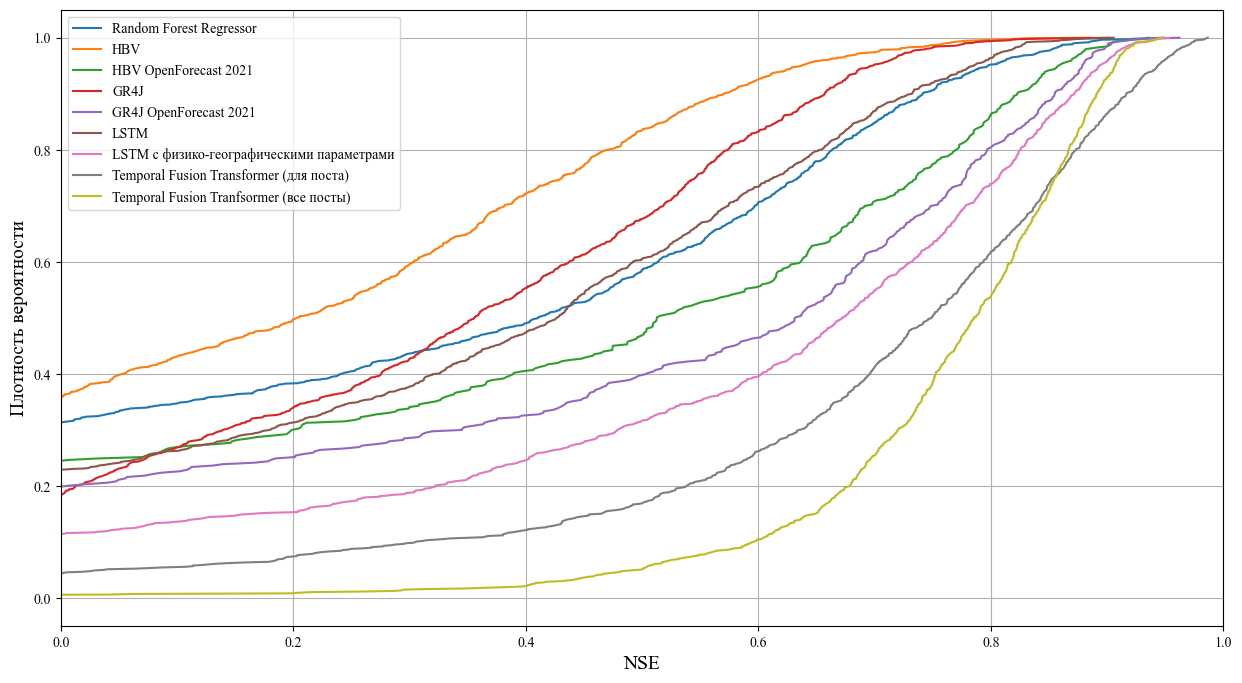

In [12]:
def ecdf(x: np.ndarray):
    """Calculate empirical cummulative density function

    Parameters
    ----------
    x : np.ndarray
        Array containing the data

    Returns
    -------
    x : np.ndarray
        Array containing the sorted metric values
    y : np.ndarray]
        Array containing the sorted cdf values
    """
    xs = np.sort(x)
    ys = np.arange(1, len(xs) + 1) / float(len(xs))
    return xs, ys


fig, ax = plt.subplots(figsize=(15, 8))

for name, fil in {'Random Forest Regressor': rfr_run['NSE'],
                  'HBV': my_hbv['NSE'],
                  'HBV OpenForecast 2021': hbv_ayzel['NSE'],
                  'GR4J': my_gr4j['NSE'],
                  'GR4J OpenForecast 2021': gr4j_ayzel['NSE'],
                  'LSTM': lstm_no_static['NSE'],
                  'LSTM с физико-географическими параметрами': lstm_era5l['NSE'],
                  'Temporal Fusion Transformer (для поста)': tft_run['NSE'],
                  'Temporal Fusion Tranfsormer (все посты)': tft_256['NSE'], }.items():

    bin_, cdf_ = ecdf(fil.to_numpy())
    plt.plot(bin_, cdf_,
             label=f'{name}')
    ax.set_xlim(0, 1)
    ax.grid(True)
    ax.legend(loc='upper left')
    ax.set_xlabel('NSE', fontsize=14)
    ax.set_ylabel('Плотность вероятности', fontsize=14)
fig.savefig('./images/CDF_models.png',
            dpi=1000, bbox_inches='tight')

### Result table for NSE

In [46]:
# random forest regressor
rfr_run, nse_rfr = metric_viewer(metric_csv='../conceptual_runs/res_rfr.csv',
                                 metric_col='NSE',
                                 gauges_file=gauges_file)
# hbv
hbv_ayzel, nse_hbv_ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE_HBV.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
gr4j_ayzel, nse_gr4j__ayzel = metric_viewer(metric_csv='./tables/DELETE_NSE.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# hbv
my_hbv, nse_hbv_my = metric_viewer(metric_csv='../conceptual_runs/final_hbv.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
# gr4j
my_gr4j, nse_gr4j_my = metric_viewer(metric_csv='../conceptual_runs/final_gr4j.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# tft (by gauge)
tft_run, nse_tft_single = metric_viewer(metric_csv='../forecast/result/tft_by_gauge.csv',
                                        metric_col='NSE',
                                        gauges_file=gauges_file)
# tft (all together)
tft_256, nse_tft_all = metric_viewer(metric_csv='../forecast/result/tft_predictions_256.csv',
                                     metric_col='NSE',
                                     gauges_file=gauges_file)
# lstm + static
lstm_era5l, nse_lstm_static = metric_viewer(metric_csv='../test_meteo_input/runs_static/era5L_static_SmallMedium_0205_095021/test/model_epoch024/test_metrics.csv',
                                            metric_col='NSE',
                                            gauges_file=gauges_file)
# lstm (only meteo)
lstm_no_static, nse_lstm_meteo = metric_viewer(metric_csv='../test_meteo_input/runs_no_static/era5Land_prcp_0604_111347/test/model_epoch030/test_metrics.csv',
                                               metric_col='NSE',
                                               gauges_file=gauges_file)

In [58]:
def nse_descriptor(nse_df: pd.DataFrame,
                   model_name: str):
    res_df = pd.DataFrame()
    res_df.loc[0, 'Модель'] = model_name
    
    res_df.loc[0, 'Объектов в выборке'] = f'{len(nse_df):.0f}'
    
    nse_max = nse_df['NSE'].max()
    res_df.loc[0, 'Максимум NSE'] = f'{nse_max:.2f}'
    
    nse_median = nse_df['NSE'].median()
    res_df.loc[0, 'Медианный NSE'] = f'{nse_median:.2f}'
    
    nse_mean = nse_df['NSE'].mean()
    res_df.loc[0, 'Средний NSE'] = f'{nse_mean:.2f}'
    
    nse_min = nse_df['NSE'].min()
    res_df.loc[0, 'Минимум NSE'] = f'{nse_min:.2f}'
    
    nse_less_t_z = (nse_df['NSE'] < 0).sum()
    res_df.loc[0, 'NSE < 0'] = f'{nse_less_t_z:.0f}'
    
    bad_models = (nse_df['NSE'] < 0.5).sum()
    res_df.loc[0, 'Плохие модели, %'] = f'{(bad_models/len(nse_df)):.0%}'
    
    return res_df

test_gr4j = deepcopy(gr4j_era5l)
test_rfr = deepcopy(rfr_era5l)

for g_id in test_gr4j.index:
    if g_id in ws_file.index:
        pass
    else:
        test_gr4j = test_gr4j.drop(g_id)

for g_id in test_rfr.index:
    if g_id in ws_file.index:
        pass
    else:
        test_rfr = test_rfr.drop(g_id)
res_list = list()

hbv_ayzel.replace([np.inf, -np.inf], np.nan, inplace=True)
hbv_ayzel.loc[hbv_ayzel.sort_values(by='NSE').head(10).index, 'NSE'] = 0
gr4j_ayzel.replace([np.inf, -np.inf], np.nan, inplace=True)


for model, res in {
    'LSTM физ. гео ERA5-Land': lstm_era5l,
    'LSTM физ. гео ERA5': lstm_era5,
    'LSTM физ. гео GPCP': lstm_gpcp,
    'LSTM физ. гео IMERG': lstm_imerg,
    'LSTM физ. гео MSWEP': lstm_mswep,
    'LSTM ERA5-Land без физ. гео': lstm_no_static.loc[lstm_era5l.index, :],
    'Temporal Fusion Transformer (для поста)': tft_era5l,
    'Temporal Fusion Transformer (все посты)': tft_all_era5l,
    'HBV, OpenForecast 2021': hbv_ayzel,
    'HBV ERA5-Land': hbv_era5l.loc[hbv_era5l.index.isin(lstm_era5l.index), :],
    'GR4J, OpenForecast 2021': gr4j_ayzel,
    'GR4J ERA5-Land': test_gr4j,
        'RandomForestRegressor ERA5-Land': test_rfr}.items():
    res_list.append(nse_descriptor(nse_df=res, model_name=model))

res_nse = pd.concat(res_list).sort_values(by='Медианный NSE',
                                ascending=False).reset_index(drop=True)
res_nse.to_csv('./tables/model_quality.csv', index=False)
res_nse

Модель Объектов в выборке Максимум NSE   
0   Temporal Fusion Transformer (все посты)                919         0.95  \
1   Temporal Fusion Transformer (для поста)                909         0.99   
2                        LSTM физ. гео ERA5                911         0.95   
3                       LSTM физ. гео MSWEP                911         0.95   
4                   LSTM физ. гео ERA5-Land                911         0.95   
5                   GR4J, OpenForecast 2021                393         0.96   
6                        LSTM физ. гео GPCP                911         0.93   
7                       LSTM физ. гео IMERG                755         0.91   
8                    HBV, OpenForecast 2021                393         0.94   
9               LSTM ERA5-Land без физ. гео                911         0.89   
10          RandomForestRegressor ERA5-Land               1013         0.95   
11                           GR4J ERA5-Land               1013         0.90   
12                            HBV ERA5-Land                909         0.89   

   Медианный NSE Средний NSE Минимум NSE NSE < 0 Плохие модели, %  
0           0.79        0.75       -2.72       5               5%  
1           0.75        0.49     -115.51      39              17%  
2           0.68        0.03     -116.63     105              32%  
3           0.68       -0.11     -113.71     115              32%  
4           0.67       -0.00     -273.15     104              32%  
5           0.64     -190.77   -51507.55      71              38%  
6           0.62       -0.06     -179.63     117              37%  
7           0.59       -0.21      -97.60     139              40%  
8           0.53        0.44       -0.38      29              45%  
9           0.44       -0.06      -28.64     172              58%  
10          0.39      -51.01   -44964.33     323              61%  
11          0.36       -0.06     -211.28     180              68%  
12          0.24        0.03       -8.35     298              83%

### TFT attributs (feature importance, attention, etc.)

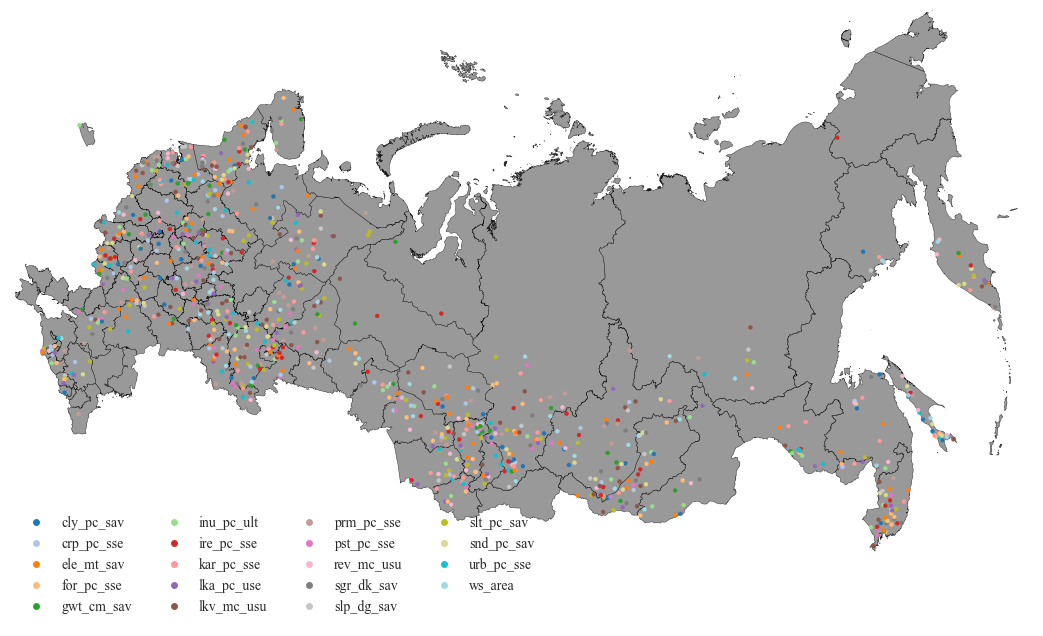

In [75]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='static',
                          cmap_name='tab20',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/static_TFT.png',
                   dpi=1500, bbox_inches='tight')

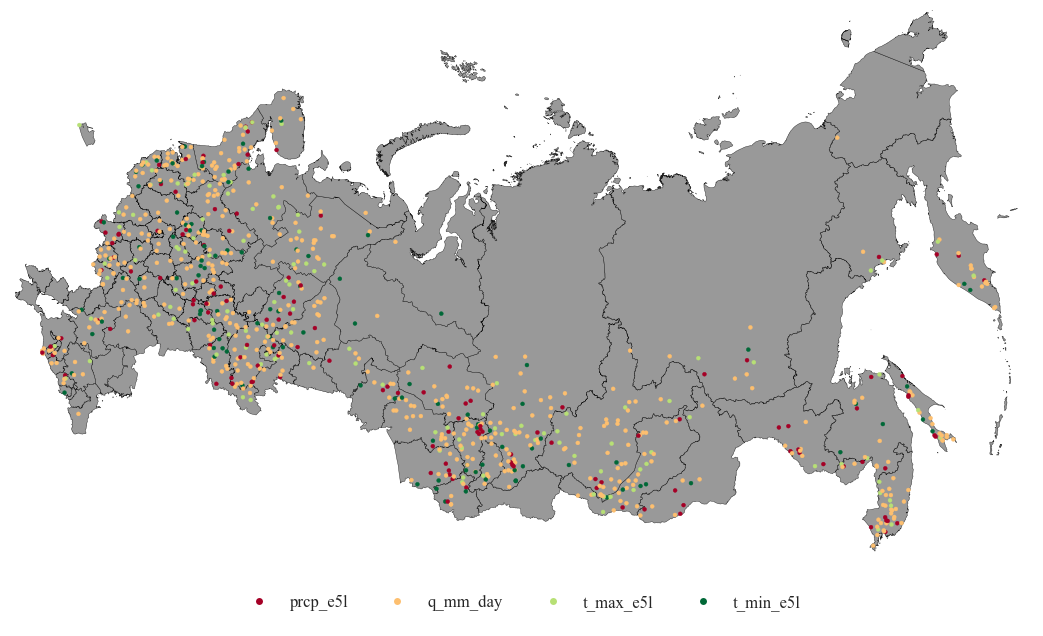

In [73]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='encoder',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/encoder_TFT.png',
                   dpi=1500, bbox_inches='tight')

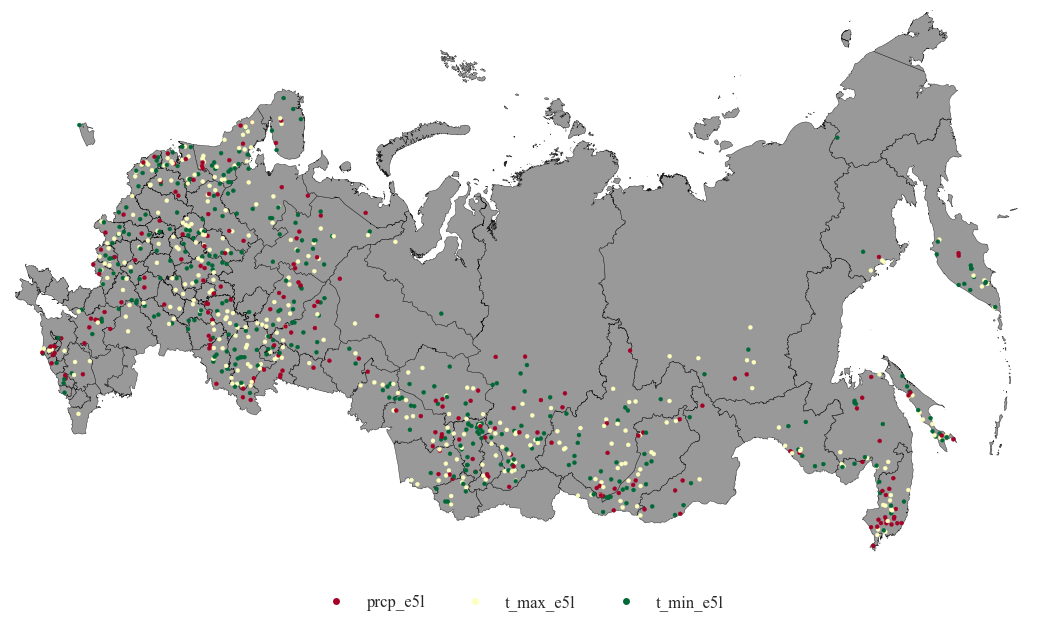

In [74]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='decoder',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/decoder_TFT.png',
                   dpi=1500, bbox_inches='tight')

In [294]:
def day_to_attnt(val: float):
    if val < 7:
        return 'Быстряя'
    elif (val >= 7) & (val <= 30):
        return 'Средняя'
    elif (val >= 30) & (val <= 90):
        return 'Средне-длинная'
    else:
        return 'Длинная'
tft_era5l['attention'] = tft_era5l['day'].apply(lambda x: day_to_attnt(x))

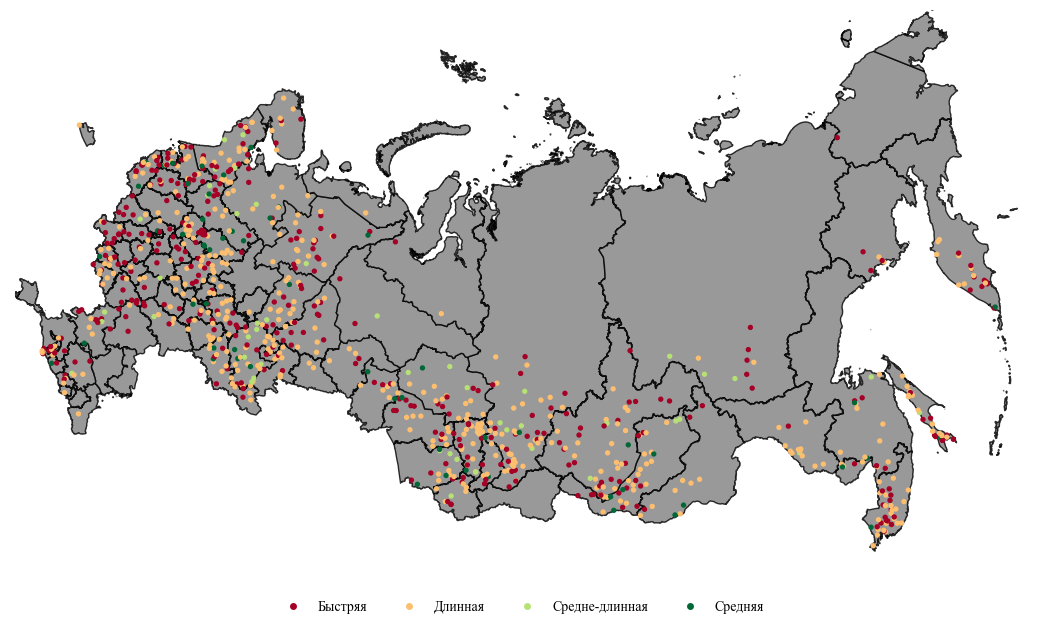

In [296]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='attention',
                          figsize=(15, 8),
                          title_text='',
                          just_points=True)
gauges_fig.savefig('./images/attention_TFT.png',
                   dpi=650, bbox_inches='tight')

### GMC forecast quality

In [15]:
def find_gmc(predictions: np.ndarray, observations: np.ndarray,
             days_shift: int, eq_param: int, with_p=False) -> np.ndarray:
    """[summary]

    Args:
        predictions (np.array): [description]
        observations (np.array): [description]
        days_shift (int): [description]

    Returns:
        np.array: [description]
    """

    predictions_error = np.array(observations - predictions)
    delta_1 = np.array(observations[:-days_shift]-observations[days_shift:])
    sigma = np.std(delta_1-np.mean(delta_1), ddof=1)
    gmc_criteria = np.abs(0.674*sigma)
    S = np.sqrt(np.sum([i**2 for i in predictions_error]) /
                (len(predictions_error)-eq_param))

    s_sigma = S/sigma

    descision = ['Прогноз оправдывается' if np.abs(error) <= gmc_criteria
                 else 'Прогноз не оправдывается'
                 for error in predictions_error]

    values, counts = np.unique(descision, return_counts=True)
    try:
        first_value, second_value = counts
        first_key, second_key = values
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{first_key} -- {first_value} раз(а),
    {second_key} -- {second_value} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = second_value/(first_value + second_value)
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {s_sigma:.2f} -- длина ряда {len(predictions_error)}')
    except:
        print(f'\nКачество прогноза заблаговременностью {days_shift} день')
        print(
            f'''Результаты оценки качества прогноза:\n{values[0]} -- {counts[0]} раз(а)''')
        print(f'Критерий точности ГМЦ +/- {gmc_criteria:.3f}')
        accuracy = 0
        print(f'Оправдываемость прогнозов по методике ГМЦ {accuracy:.2%}')
        print(
            f'S/sigma_delta {s_sigma:.2f} -- длина ряда {len(predictions_error)}')
    if with_p:
        return np.array([np.round(S*100, decimals=1),
                         np.round(sigma*100, decimals=1),
                         np.round(s_sigma, decimals=2),
                         f'{accuracy:.1%}'])

    else:
        return np.array([np.round(gmc_criteria, decimals=3),
                         np.round(s_sigma, decimals=2),
                         np.round(accuracy*100, decimals=2)])

In [16]:
for gauge_id in tft_era5l.index:
    test_df = pd.read_csv(f'./results/tft_single/{gauge_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    tft_era5l.loc[gauge_id, ['S/σ', 'ГМЦ']] = find_gmc(
        predictions=test_df['q_mm_day_pred'].to_numpy(),
        observations=test_df['q_mm_day'].to_numpy(),
        days_shift=7, eq_param=24, with_p=False)[1:3]
for i, geom in enumerate(tqdm(ugms_shp['geometry'])):

    ugms_part = tft_era5l.loc[[geom.intersects(gage_point)
                              for gage_point in tft_era5l['geometry']], :]
    ugms_name = ugms_shp.loc[i, 'name1']

    ugms_shp.loc[i, ['ГМЦ']] = ugms_part[['ГМЦ']].mean()
    ugms_shp.loc[i, ['S/σ']] = ugms_part[['S/σ']].min()
    
ugms_shp.loc[[25, 26, 27], ['ГМЦ', 'S/σ']] = np.NaN

In [17]:
def s_sigma_to_qual(val: float):
    if val <= 0.5:
        return 'Хорошая'
    elif (0.5 < val) & (val <= 0.8):
        return 'Удовлетворительная'
    else:
        return 'Плохая'
tft_era5l['S/σ'] = tft_era5l['S/σ'].apply(lambda x: s_sigma_to_qual(x))

In [91]:
s_sigma_df = pd.DataFrame()
for i, (qual, idx) in enumerate(tft_era5l.groupby('S/σ').groups.items()):
    s_sigma_df.loc[0, f'{qual}'] = len(idx)
s_sigma_df
    

Плохая  Удовлетворительная  Хорошая
0   243.0               531.0    135.0

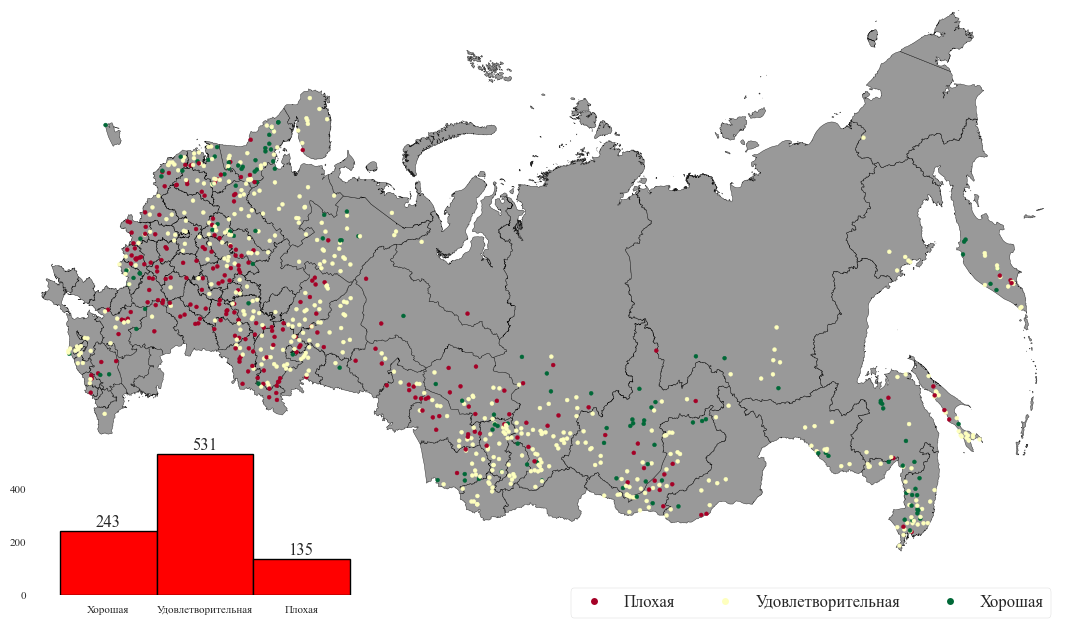

In [22]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='S/σ',
                          just_points=True,
                          specific_xlabel=['Хорошая', 'Удовлетворительная',
                                           'Плохая'],
                          figsize=(15, 8),
                          title_text='',
                          with_histogram=True,)
gauges_fig.savefig('./images/s_sigma_tft.png',
                   dpi=1500, bbox_inches='tight')

In [29]:
tft_era5l['ГМЦ']

gauge_id
49014    94.90
49047    83.17
49052    84.55
49058    91.72
49070    89.24
         ...  
5664     86.62
49053    90.90
2107     72.28
2106     71.45
7176     99.31
Name: ГМЦ, Length: 909, dtype: float64

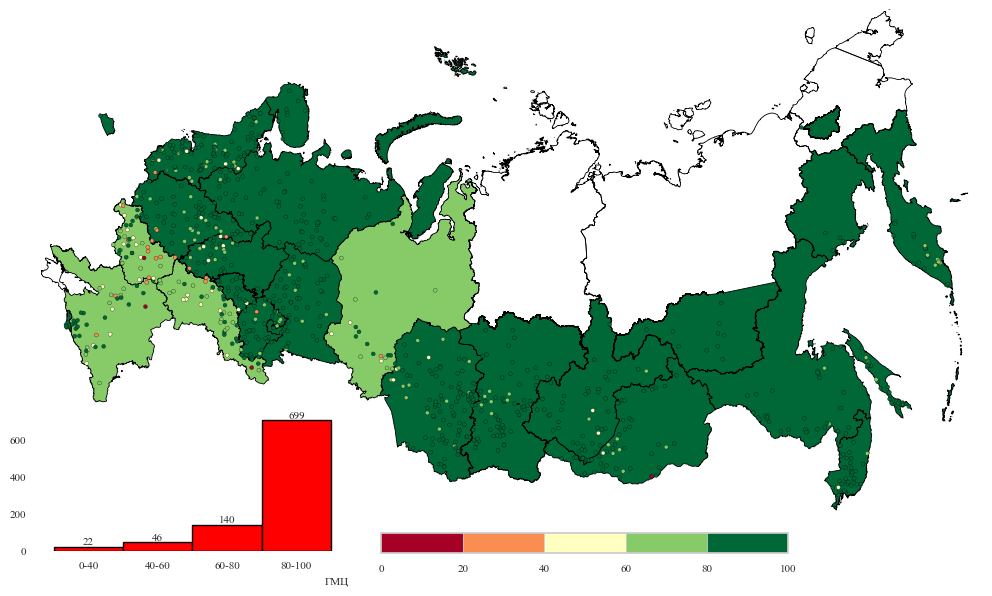

In [30]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='',
                          list_of_limits=[0, 40, 60, 80, 100],
                          cmap_lims=(0, 100),
                          figsize=(15, 8),
                          title_text='',
                          with_histogram=True,
                          ugms=True, ugms_gdf=ugms_shp, metric_col='ГМЦ')
gauges_fig.savefig('./images/GMC_tft.png',
                   dpi=1500, bbox_inches='tight')

In [366]:
test_df = pd.read_csv('./results/tft_single/10044.csv',
                      index_col='date')
test_df.index = pd.to_datetime(test_df.index)
test_df

q_mm_day  q_mm_day_pred
date                               
2019-01-01  0.229353       0.256738
2019-01-02  0.223678       0.231382
2019-01-03  0.218002       0.239144
2019-01-04  0.212327       0.235815
2019-01-05  0.206652       0.251356
...              ...            ...
2020-12-21  0.360555       0.348478
2020-12-22  0.353878       0.347604
2020-12-23  0.347201       0.372509
2020-12-24  0.340524       0.432434
2020-12-25  0.331511       0.468575

[725 rows x 2 columns]

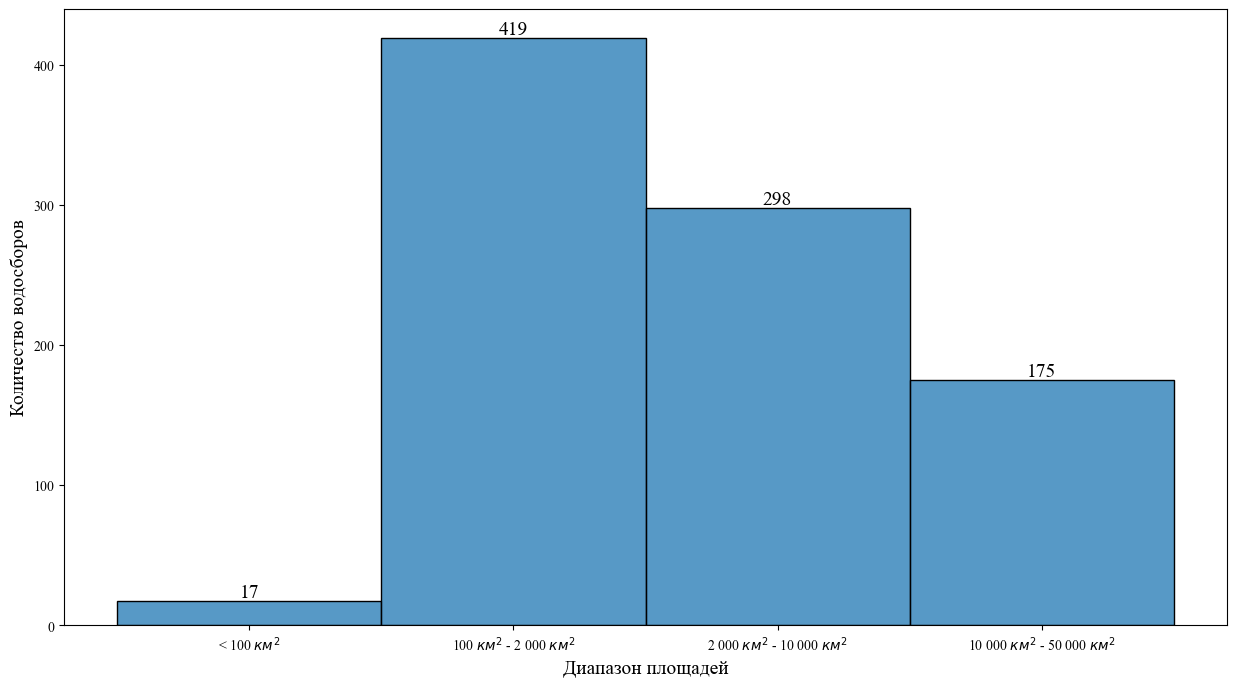

In [113]:

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(15, 8))

area_hist = sns.histplot(data=ws_file,
                         x='size')
#  set the ticks first
area_hist.set_yticks(np.arange(0, 500, 100));
# set the labels
area_hist.set_yticklabels(np.arange(0, 500, 100));
area_hist.set_xlabel('Диапазон площадей', fontsize=14)
area_hist.set_ylabel('Количество водосборов', fontsize=14)
area_hist.bar_label(area_hist.containers[1], fmt='%.0f', fontsize=14)

# area_hist.set_title(f"""Распределение водосборов по площадям""", fontsize=12);
plt.savefig('./images/area_distribution.png',
            dpi=1000, bbox_inches='tight')

In [35]:
stat_nse_qual = pd.DataFrame()

for i, (stat_attr, indx) in enumerate(
    tft_era5l.groupby('static').groups.items()):
    
    stat_nse_qual.loc[i, 'Физико-географический атрибут'] = stat_attr
    stat_nse_qual.loc[i, 'NSE'] = tft_era5l.loc[indx, 'NSE'].mean()
    

In [41]:
stat_nse_qual

Физико-географический атрибут       NSE
0                     cly_pc_sav  0.547012
1                     crp_pc_sse  0.380154
2                     ele_mt_sav  0.636396
3                     for_pc_sse  0.685875
4                     gwt_cm_sav  0.624563
5                     inu_pc_ult  0.654382
6                     ire_pc_sse  0.556711
7                     kar_pc_sse  0.708467
8                     lka_pc_use  0.686307
9                     lkv_mc_usu  0.572746
10                    prm_pc_sse  0.635245
11                    pst_pc_sse  0.610373
12                    rev_mc_usu  0.679000
13                    sgr_dk_sav  0.710811
14                    slp_dg_sav  0.695742
15                    slt_pc_sav  0.701114
16                    snd_pc_sav  0.433128
17                    urb_pc_sse -2.120386
18                       ws_area  0.510478

In [49]:
ws_file['NSE'] = tft_era5l['NSE']
ws_file['ГМЦ'] = tft_era5l['ГМЦ']
ws_file['S/σ'] = tft_era5l['S/σ']

In [50]:
ws_file

name_ru                            name_en   
gauge_id                                                                        
49014        р.Корпи-Йоки - пос.Пяозерский     r.Korpi-Joki - pos.Pjaozerskij  \
49047               р.Судно - с.Вокнаволок             r.Sudno - s.Voknavolok   
49052                р.Ухта - пгт Калевала              r.Uhta - pgt Kalevala   
49058            р.Чирко-Кемь - с.Юшкозеро       r.Chirko-Kem' - s.Jushkozero   
49070                  р.Шуя - с.Шуерецкое            r.Shuja - s.Shueretskoe   
...                                    ...                                ...   
5664       р.Левый Ул - пос.Многовершинный   r.Levyj Ul - pos.Mnogovershinnyj   
49053          р.Норви-Йоки - пгт Калевала        r.Norvi-Joki - pgt Kalevala   
2107               р.Половинка - г.Елизово            r.Polovinka - g.Elizovo   
2106      р.Половинка - в 13.7 км от устья  r.Polovinka - v 13.7 km ot ust'ja   
7176               р.Слюдянка - г.Слюдянка        r.Sljudjanka - g.Sljudjanka   

          new_area  ais_dif   
gauge_id                      
49014      223.222    2.867  \
49047     1179.065    1.644   
49052      360.026    0.270   
49058     8153.042    0.815   
49070      935.469    0.157   
...            ...      ...   
5664        20.686   13.660   
49053       55.187   10.411   
2107        89.077    1.572   
2106        29.993    1.671   
7176        55.561    1.312   

                                                   geometry   
gauge_id                                                      
49014     POLYGON ((31.06042 65.78292, 31.06042 65.78208...  \
49047     POLYGON ((29.92292 65.19542, 29.92708 65.19542...   
49052     POLYGON ((30.98042 65.47125, 30.98375 65.47125...   
49058     POLYGON ((32.11458 64.75292, 32.11542 64.75292...   
49070     POLYGON ((34.11125 64.83542, 34.11125 64.83458...   
...                                                     ...   
5664      POLYGON ((139.77875 53.66708, 139.78042 53.667...   
49053     POLYGON ((31.24208 65.30125, 31.24458 65.30125...   
2107      POLYGON ((158.30125 53.21875, 158.30292 53.218...   
2106      POLYGON ((158.18542 53.18125, 158.18792 53.181...   
7176      POLYGON ((103.68625 51.64542, 103.68708 51.645...   

                                  size       NSE    ГМЦ                 S/σ  
gauge_id                                                                     
49014        100 $км^2$ - 2 000 $км^2$  0.949277  94.90             Хорошая  
49047        100 $км^2$ - 2 000 $км^2$  0.951980  83.17  Удовлетворительная  
49052        100 $км^2$ - 2 000 $км^2$  0.732684  84.55  Удовлетворительная  
49058     2 000 $км^2$ - 10 000 $км^2$  0.975160  91.72             Хорошая  
49070        100 $км^2$ - 2 000 $км^2$  0.744663  89.24  Удовлетворительная  
...                                ...       ...    ...                 ...  
5664                      < 100 $км^2$  0.843053  86.62  Удовлетворительная  
49053                     < 100 $км^2$  0.953800  90.90  Удовлетворительная  
2107                      < 100 $км^2$  0.927761  72.28  Удовлетворительная  
2106                      < 100 $км^2$  0.838575  71.45              Плохая  
7176                      < 100 $км^2$  0.193418  99.31  Удовлетворительная  

[909 rows x 9 columns]

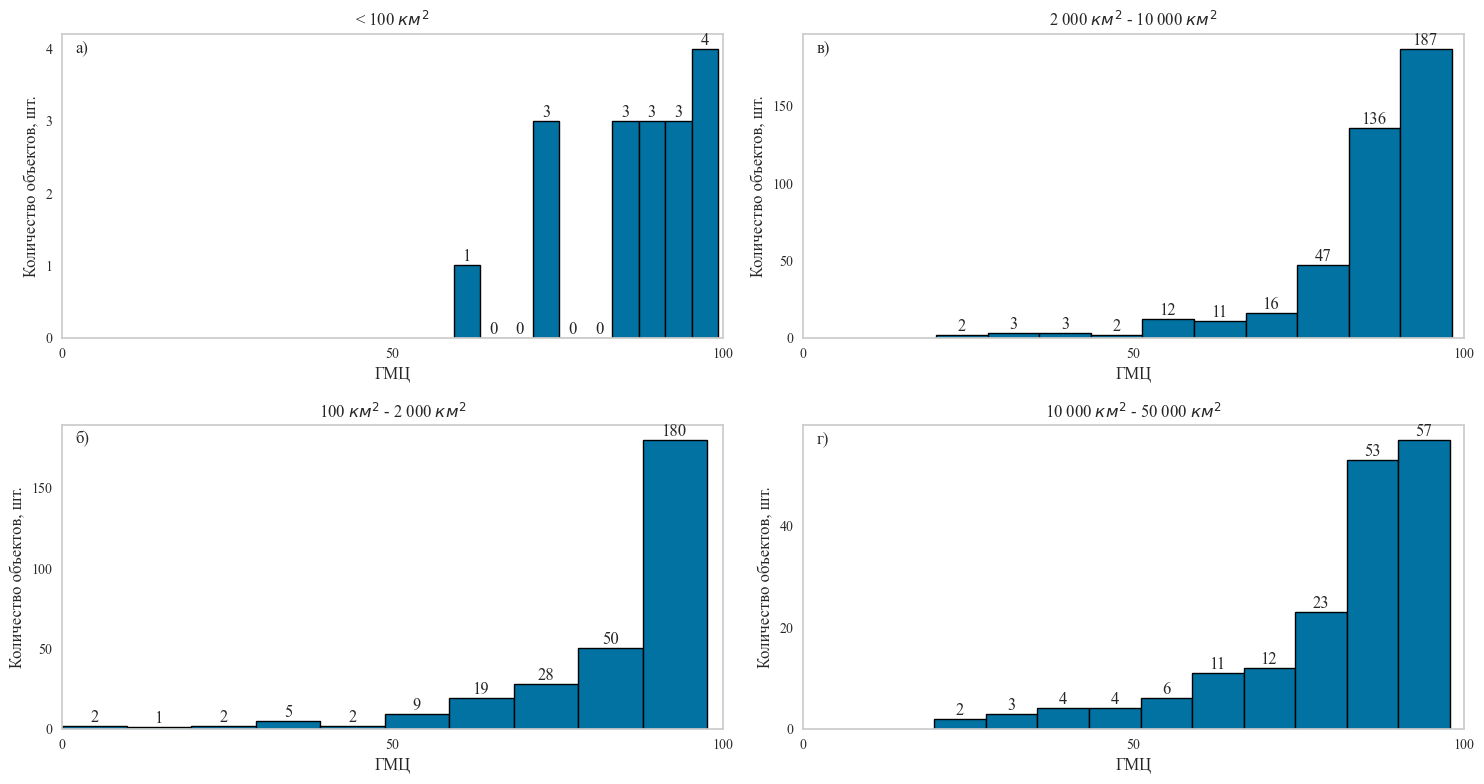

In [64]:
my_hist = ws_file.hist(column='ГМЦ',
                       by='size',
                       figsize=(15, 8),
                       edgecolor='black', linewidth=1)

xlbl = [str(col).replace(', ', '-')
        for col in np.unique(ws_file['size'])]
label_list = ['а)', 'в)', 'б)', 'г)'][::-1]

for i, ax in enumerate(my_hist.flatten()[::-1]):
    ax.set_title(xlbl[i])
    ax.text(.02, .98, label_list[i], ha='left', va='top',
        transform=ax.transAxes, fontsize=12)
    ax.set_xlabel("ГМЦ", fontsize=12)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax.set_ylabel('Количество объектов, шт.', fontsize=12)
    ax.locator_params(axis='y', nbins=5)
    ax.set_xlim((0, 100))
    ax.locator_params(axis='x', nbins=3)
    ax.grid(False)
    ax.bar_label(ax.containers[0], fmt='%.0f'.lstrip('0'))
    ax.tick_params(axis='x', labelrotation=0);
plt.tight_layout()
plt.savefig('./images/gmc_distribution.png',
            dpi=1500, bbox_inches='tight')


### q5, q95, mean, baseflow 

In [4]:
from scripts.hydro_metrics import hydro_job
from scripts.processing import split_by_hydro_year, split_by_year

In [10]:
gage_comp = dict()
final_list = list()
for g_id in tqdm(ws_file.index):
    gage_comp[g_id] = dict()
    test_df = pd.read_csv(f'./results/tft_256/{g_id}.csv',
                      index_col='date')
    test_df.index = pd.to_datetime(test_df.index)
    for col in test_df.columns:
        year_res = list()
        hydro_years = split_by_hydro_year(test_df[col])
        calendar_years = split_by_year(test_df[col])

        for year in hydro_years.keys():
            year_res.append(pd.DataFrame(hydro_job(hydro_year=hydro_years[year],
                                                   calendar_year=calendar_years[year]),
                                         index=[0]))
        year_res = pd.concat(year_res)
        gage_comp[g_id][col] = year_res
    res_df = (gage_comp[g_id]['q_mm_day'] - gage_comp[g_id]
              ['q_mm_day_pred'])/gage_comp[g_id]['q_mm_day'] * 100
    res_df = res_df.mean().to_frame().T
    res_df['gauge_id'] = g_id
    final_list.append(res_df)
tft_stats = pd.concat(final_list).set_index('gauge_id', drop=True)

A Jupyter Widget

In [11]:
tft_era5l[['mean', 'bfi', 'q5', 'q95']] = tft_stats

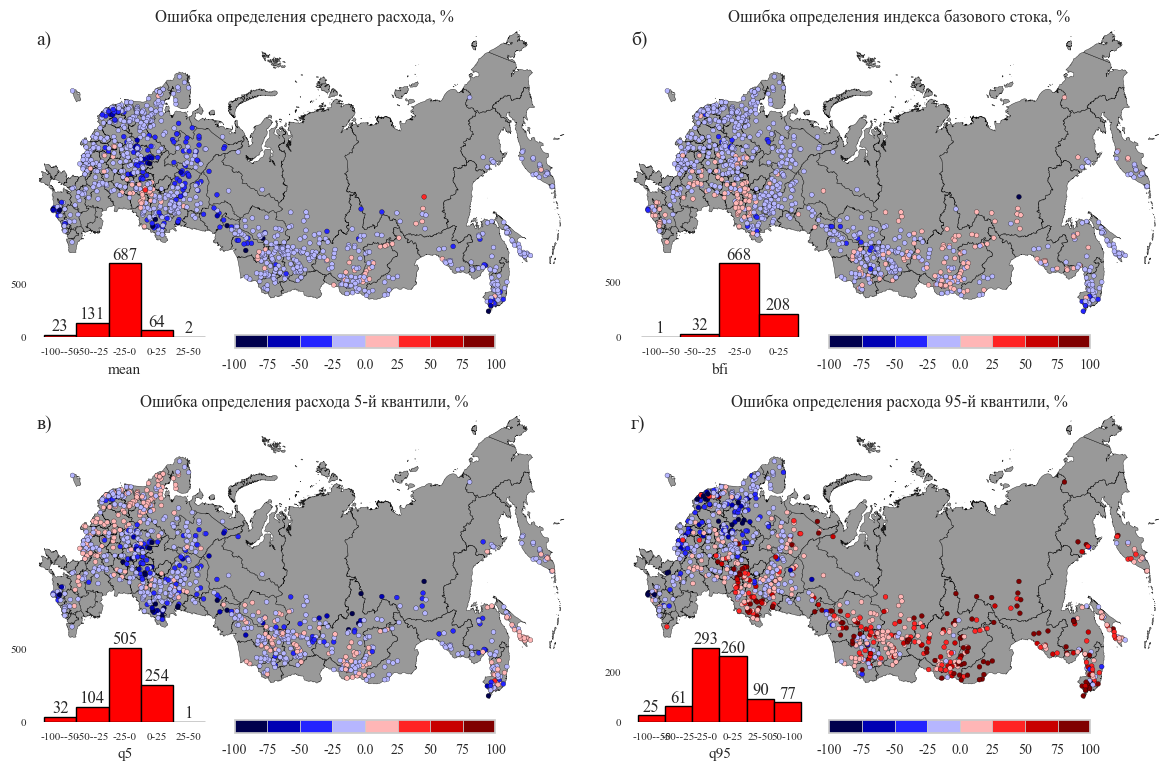

In [16]:
russia_plots_n(gdf_to_plot=tft_era5l,
               basemap_data=basemap_data,
               cmap_name='seismic',
               figsize=(15, 8),
               list_of_limits=[-100, -50, -25, 0, 25, 50, 100],
               cmap_lims=(-100, 100),
               label_list= ['а)', 'б)', 'в)', 'г)'],
               nrows=2,
               ncols=2,
               columns_from_gdf=['mean', 'bfi', 'q5', 'q95'],
               with_histogram=True, title_text=[f'Ошибка определения среднего расхода, %',
                                                f'Ошибка определения индекса базового стока, %',
                                                f'Ошибка определения расхода 5-й квантили, %',
                                                f'Ошибка определения расхода 95-й квантили, %']);
plt.savefig('./images/q5q95bfimean.png',
            dpi=1500, bbox_inches='tight')

### Static parameters description

In [115]:
static_params = pd.read_csv('../geo_data/attributes/geo_vector.csv')
static_params = static_params.set_index('gauge_id')
static_parameters = ['for_pc_sse', 'crp_pc_sse',
                     'inu_pc_ult', 'ire_pc_sse',
                     'lka_pc_use', 'prm_pc_sse',
                     'pst_pc_sse', 'cly_pc_sav',
                     'slt_pc_sav', 'snd_pc_sav',
                     'kar_pc_sse', 'urb_pc_sse',
                     'gwt_cm_sav', 'lkv_mc_usu',
                     'rev_mc_usu', 'sgr_dk_sav',
                     'slp_dg_sav', 'ws_area',
                     'ele_mt_sav']
static_final = static_params[static_parameters]

test_static = deepcopy(static_final)

In [121]:

for g_id in test_static.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static = test_static.drop(g_id)
        
test_static_big = deepcopy(static_params)
for g_id in test_static_big.index:
    if str(g_id) in tft_era5l.index:
        pass
    else:
        test_static_big = test_static_big.drop(g_id)

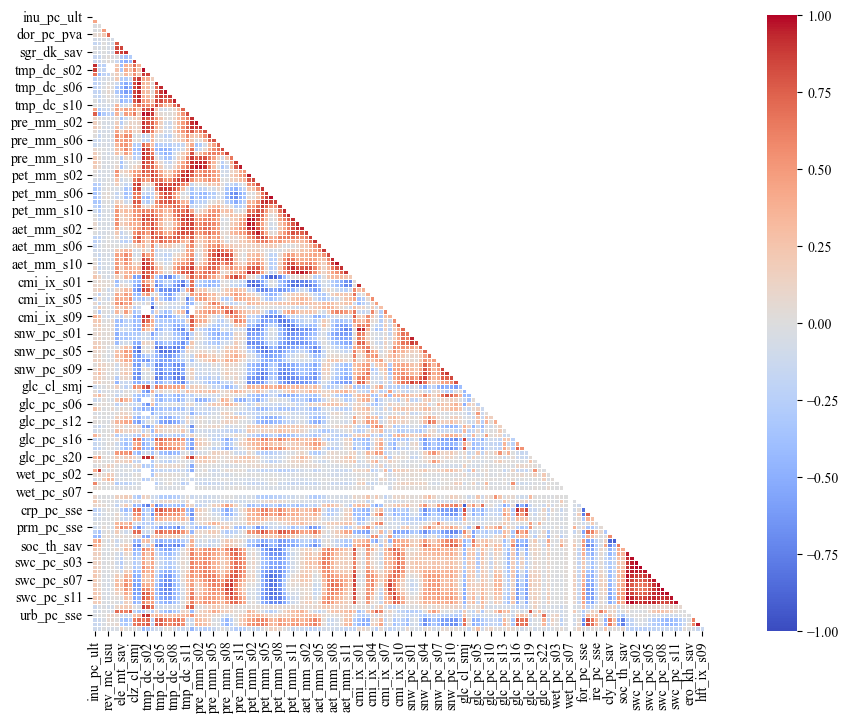

In [15]:
plt.rcParams["font.family"] = "Times New Roman"
# remove columns which had no representation in data
corr_frame = test_static_big.drop(['glc_pc_s01', 'glc_pc_s03',
                                   'glc_pc_s07', 'glc_pc_s08',
                                   'wet_pc_s05'], axis=1)
correlation_matrix = corr_frame.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 1});
plt.savefig('./images/corr_mat_everything.png',
            dpi=650, bbox_inches='tight')


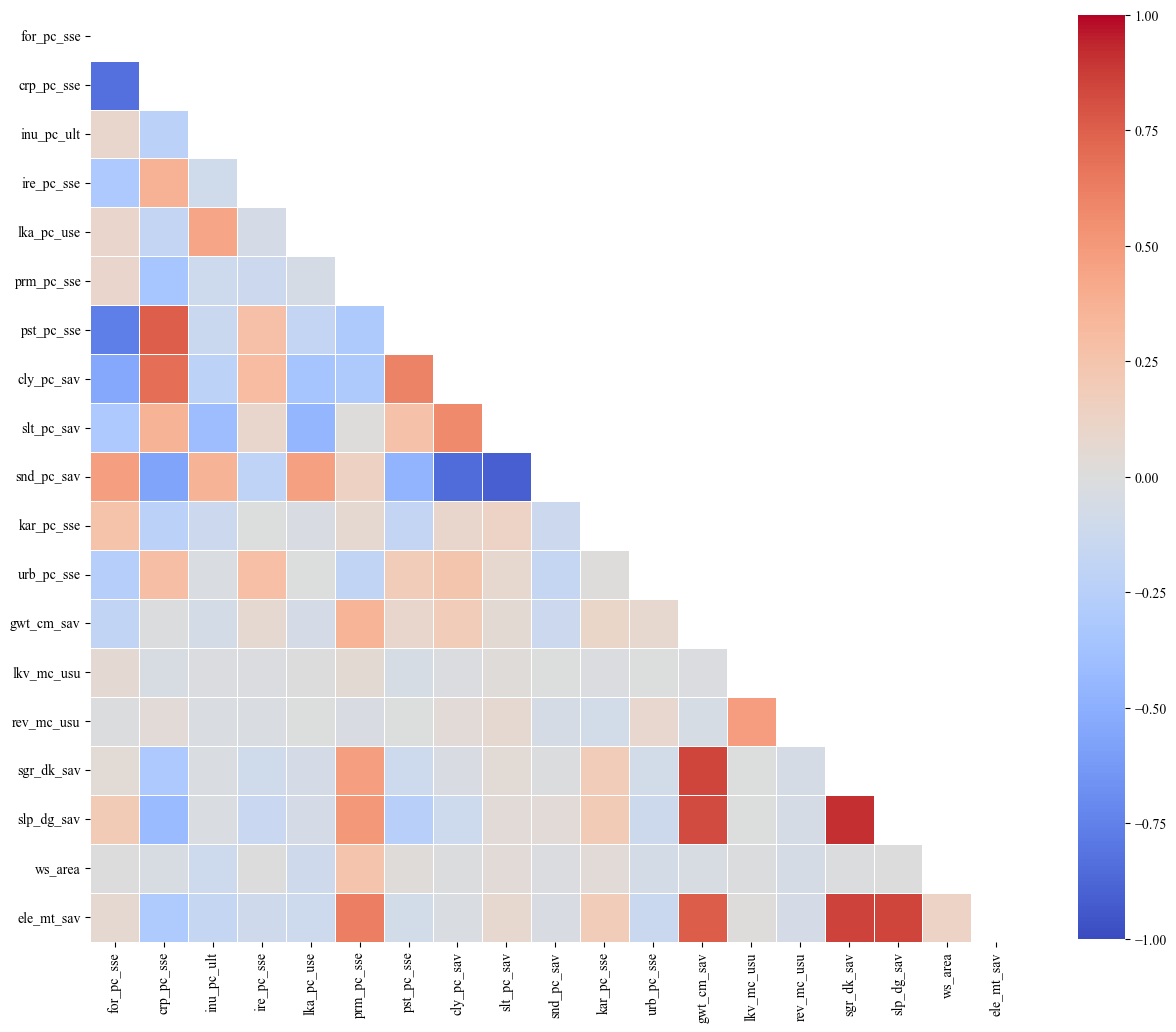

In [354]:
# remove columns which had no representation in data
correlation_matrix = test_static.corr()
correlation_matrix = correlation_matrix.where(
    np.tril(np.ones(correlation_matrix.shape), k=-1).astype(bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', ax=ax,
            robust=True,
            vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8});
plt.savefig('./images/corr_mat_final.png',
            dpi=650, bbox_inches='tight')


In [125]:



def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42, n_init=500)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results,
                          columns=["Количество кластеров", "Величина силуэта"])
    pivot_km = pd.pivot_table(result,
                              index="Количество кластеров",
                              values="Величина силуэта")
    pivot_km = pivot_km.rename(columns={"Величина силуэта": ''})

    fig = plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_km, annot=True, linewidths=1,
                fmt='.3f', cmap='RdYlGn', cbar=False)

    plt.tight_layout()
    plt.ylabel('Количество кластеров, шт.', fontsize=12)
    plt.xlabel('Величина "силуэта"', fontsize=12)
    plt.show()
    
    return fig, pivot_km

### Clusters based on static values order in tft

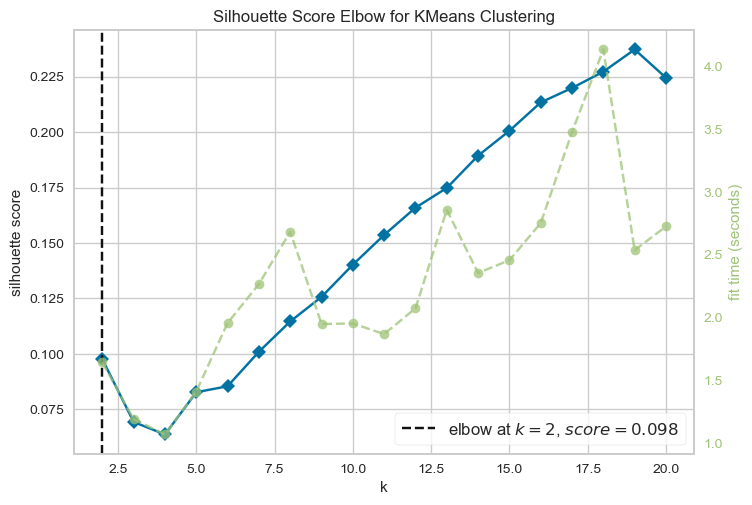

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [63]:
tft_static = pd.read_csv('../forecast/result/tft_by_gauge_static_final.csv')
tft_static['gauge_id'] = tft_static['gauge_id'].astype(str)
tft_static = tft_static.set_index('gauge_id', drop=True)
tft_static = tft_static.loc[tft_static.index.isin(tft_era5l.index), :]
km = KMeans(n_init=500)
Elbow_M = KElbowVisualizer(estimator = km, k = 20, metric='silhouette')
Elbow_M.fit(tft_static.to_numpy())
Elbow_M.show()

In [83]:
tft_cluster = deepcopy(tft_era5l.loc[tft_era5l.index.isin(tft_static.index)])


def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


km = KMeans(n_clusters=9, random_state=42, n_init=500)

yhat_AC = km.fit_predict(tft_static.to_numpy())

tft_cluster['Кластер_tft'] = [str(f'Кластер {i+1}')for i in yhat_AC]
tft_static['ResClust'] = [i+1 for i in yhat_AC]
tft_cluster['importance'] = tft_static.idxmax(axis=1)

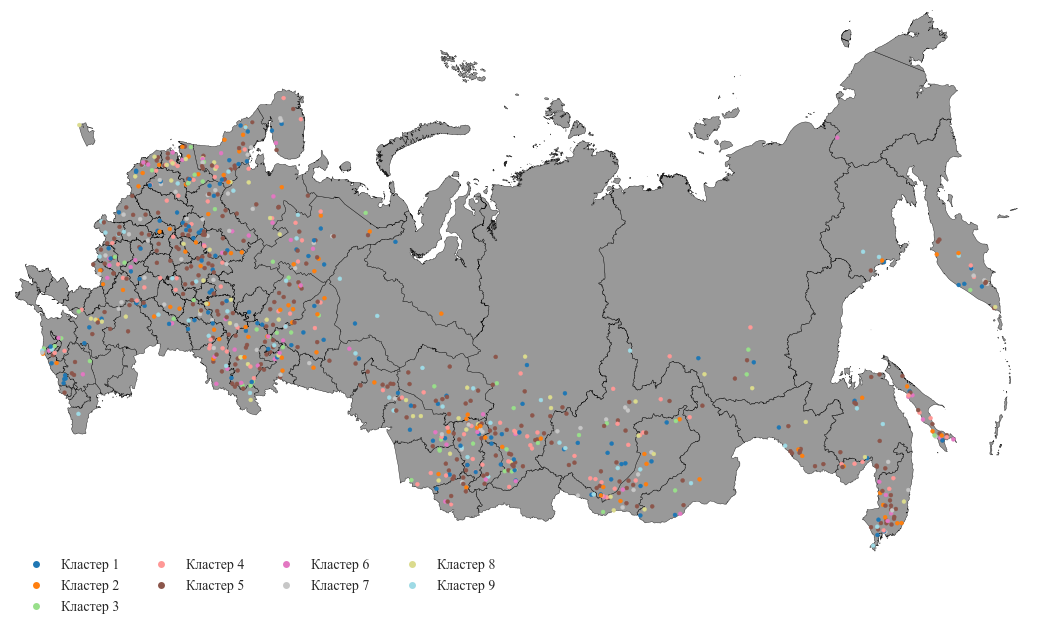

In [84]:
gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='Кластер_tft',
                          cmap_name='tab20',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)
# gauges_fig.savefig('./images/clusters_Rus_tft.png',
#                    dpi=1500, bbox_inches='tight')

In [86]:
cmap_name: str = 'tab20'
cmap = cm.get_cmap(cmap_name)
color_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

polar = tft_static.groupby('ResClust').mean().reset_index()

polar = pd.melt(polar, id_vars=['ResClust'])


fig_polar = px.line_polar(polar, r='value', theta='variable',
                          color='ResClust', color_discrete_sequence=color_list,
                          template='seaborn', height=800, width=800)
fig_polar.update_layout(
    polar=dict(
        # radialaxis_angle = -45
        radialaxis=dict(showticklabels=False, ticks=''),
        angularaxis=dict(showticklabels=True, tickangle=0)
    ),
    legend_title_text='Кластеры',
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0
    )
)
fig_polar.write_image('./images/cluster_importance_tft.png')
fig_polar

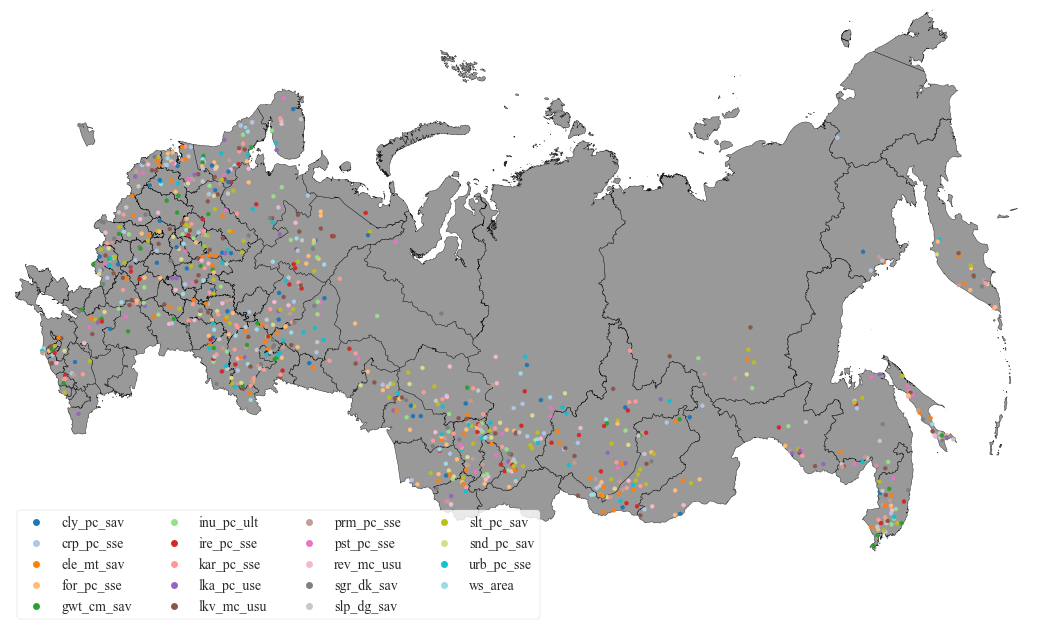

In [143]:
gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='importance',
                          cmap_name='tab20',
                          list_of_limits=[i for
                                          i in 
                                          range(len(
                                            tft_cluster['importance'].unique()))],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)
gauges_fig.savefig('./images/clusters_Rus_tft_max_impact.png',
                   dpi=1000, bbox_inches='tight')

In [148]:
{val: len(g) for val, g in tft_cluster.groupby('importance').groups.items()}

{'cly_pc_sav': 42,
 'crp_pc_sse': 49,
 'ele_mt_sav': 64,
 'for_pc_sse': 65,
 'gwt_cm_sav': 37,
 'inu_pc_ult': 45,
 'ire_pc_sse': 45,
 'kar_pc_sse': 58,
 'lka_pc_use': 26,
 'lkv_mc_usu': 74,
 'prm_pc_sse': 56,
 'pst_pc_sse': 33,
 'rev_mc_usu': 39,
 'sgr_dk_sav': 42,
 'slp_dg_sav': 40,
 'slt_pc_sav': 72,
 'snd_pc_sav': 38,
 'urb_pc_sse': 46,
 'ws_area': 37}

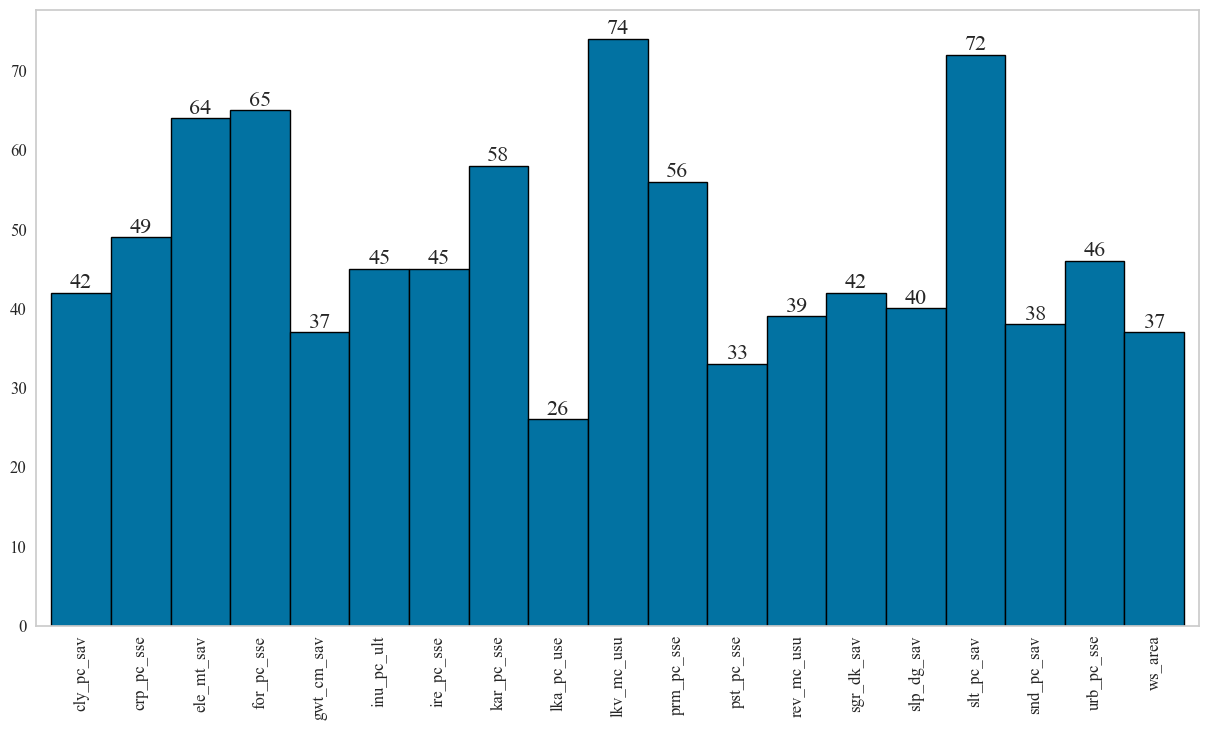

In [79]:
clust_hist = pd.DataFrame({val: len(g) for val, g in tft_cluster.groupby('importance').groups.items()},
                          index=[0]).T.plot.bar(figsize=(15, 8),
                                                rot=90,
                                                width=1,
                                                edgecolor='black',
                                                grid=False, legend=False,
                                                lw=1)
clust_hist.bar_label(clust_hist.containers[0], fmt='%.0f',
                     fontsize=16);
plt.setp(clust_hist.get_xticklabels(),
            fontsize=12)
plt.setp(clust_hist.get_yticklabels(),
            fontsize=12);
plt.savefig('./images/clust_dominance.png',
            dpi=1000, bbox_inches='tight')

In [ ]:
# tft single era5l
tft_static, nse_tft = metric_viewer(metric_csv='../forecast/result/tft_by_gauge_static_final.csv',
                                   metric_col='NSE',
                                   gauges_file=gauges_file)
tft_test_cluster = deepcopy(tft_static[['static']])
import ast

static_dict = {param: code+1 for code, param
               in zip(pd.Categorical(static_parameters).codes,
                      static_parameters)}

def static_as_int(static_dict: dict,
                  row):
    return list(map(lambda x: static_dict[x],
                    ast.literal_eval(row)))

for g in tft_test_cluster.index:
    tft_test_cluster.loc[g, ['x1', 'x2', 'x3', 'x4']] = static_as_int(
        static_dict=static_dict,
        row=tft_test_cluster.loc[g, 'static'])
tft_test_cluster = tft_test_cluster[['x1', 'x2', 'x3', 'x4']]

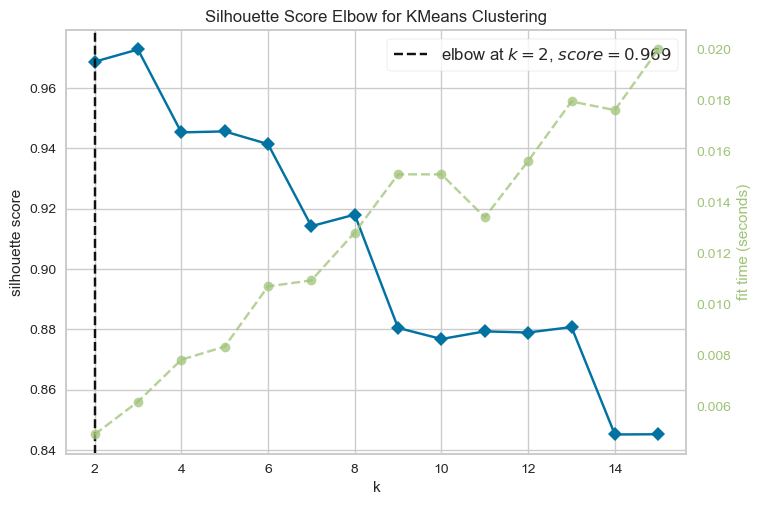

In [23]:
km = KMeans(n_init=6)
Elbow_M = KElbowVisualizer(estimator = km, k = 15, metric='silhouette')
Elbow_M.fit(test_static.to_numpy())
Elbow_M.show()


def visualize_silhouette_layer(data):
    clusters_range = range(2,10)
    results = []

    for i in clusters_range:
        km = KMeans(n_clusters=i, random_state=42, n_init=6)
        cluster_labels = km.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results,
                          columns=["Количество кластеров", "Величина силуэта"])
    pivot_km = pd.pivot_table(result,
                              index="Количество кластеров",
                              values="Величина силуэта")
    pivot_km = pivot_km.rename(columns={"Величина силуэта": ''})

    fig = plt.figure(figsize=(15, 8))
    sns.heatmap(pivot_km, annot=True, linewidths=1,
                fmt='.3f', cmap='RdYlGn', cbar=False)

    plt.tight_layout()
    plt.ylabel('Количество кластеров, шт.', fontsize=12)
    plt.xlabel('Величина "силуэта"', fontsize=12)
    plt.show()
    
    return fig, pivot_km

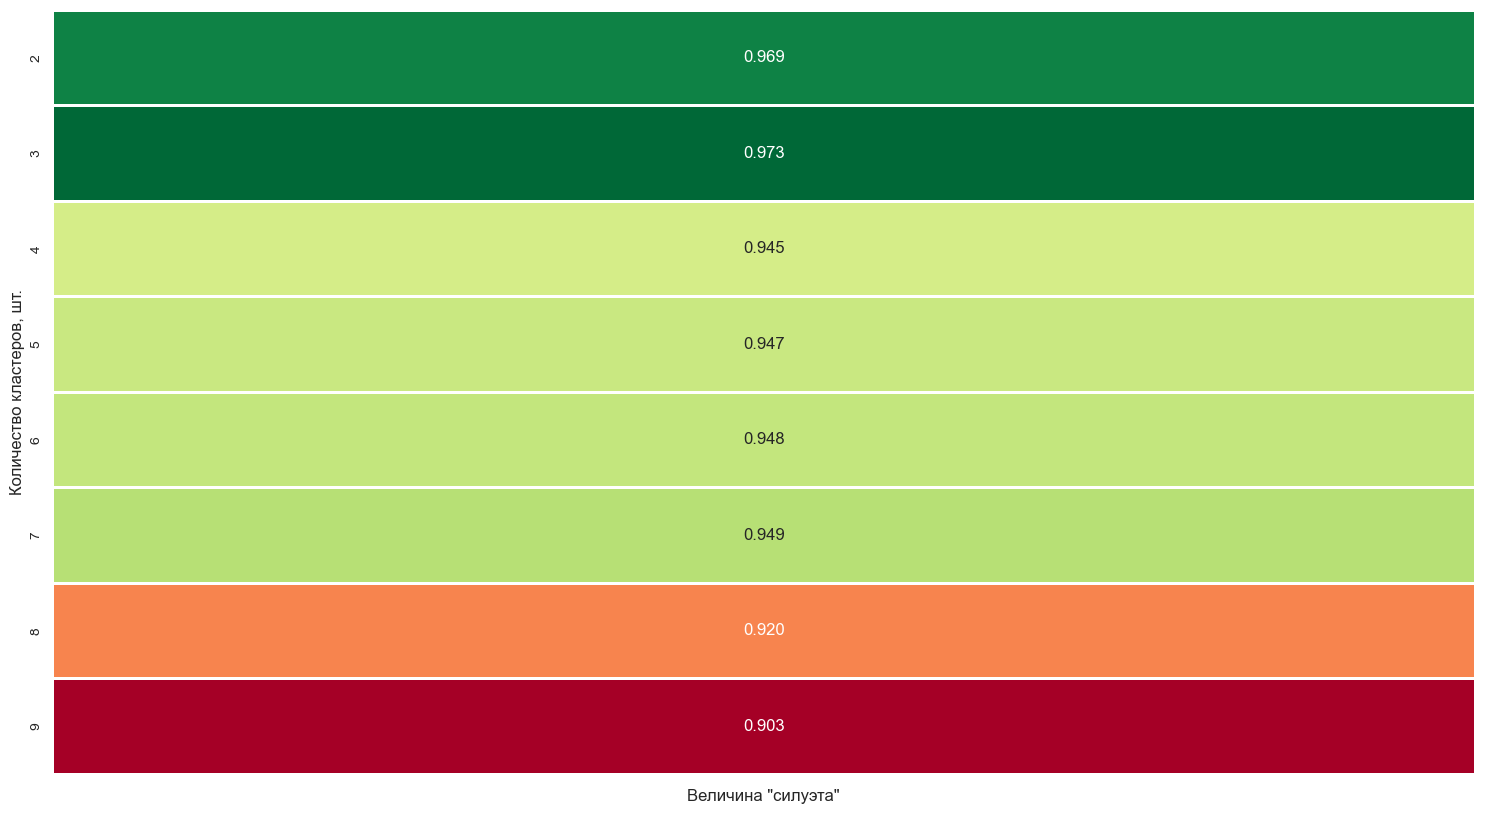

In [24]:
sil_fig, table = visualize_silhouette_layer(test_static.to_numpy())
sil_fig.savefig('./images/clusters_number.png',
                dpi=650, bbox_inches='tight')

In [210]:
tft_test_cluster = tft_test_cluster[tft_test_cluster.index.isin(
    tft_era5l.index)]

tft_cluster = deepcopy(tft_era5l)
tft_cluster = tft_cluster[tft_cluster.index.isin(tft_test_cluster.index)]

In [296]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(tft_static))

tft_cluster['Кластер_tft'] = [str(f'Кластер {i+1}')for i in yhat_AC]
tft_static['ResClust'] = [i+1 for i in yhat_AC]


/tmp/ipykernel_978474/583339828.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tft_static['ResClust'] = [i+1 for i in yhat_AC]


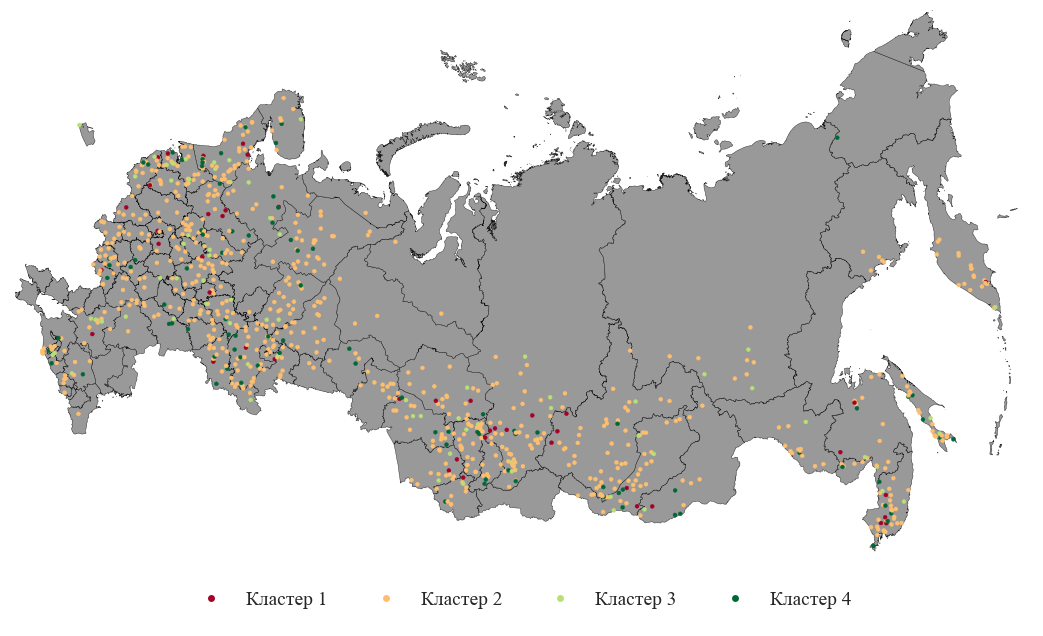

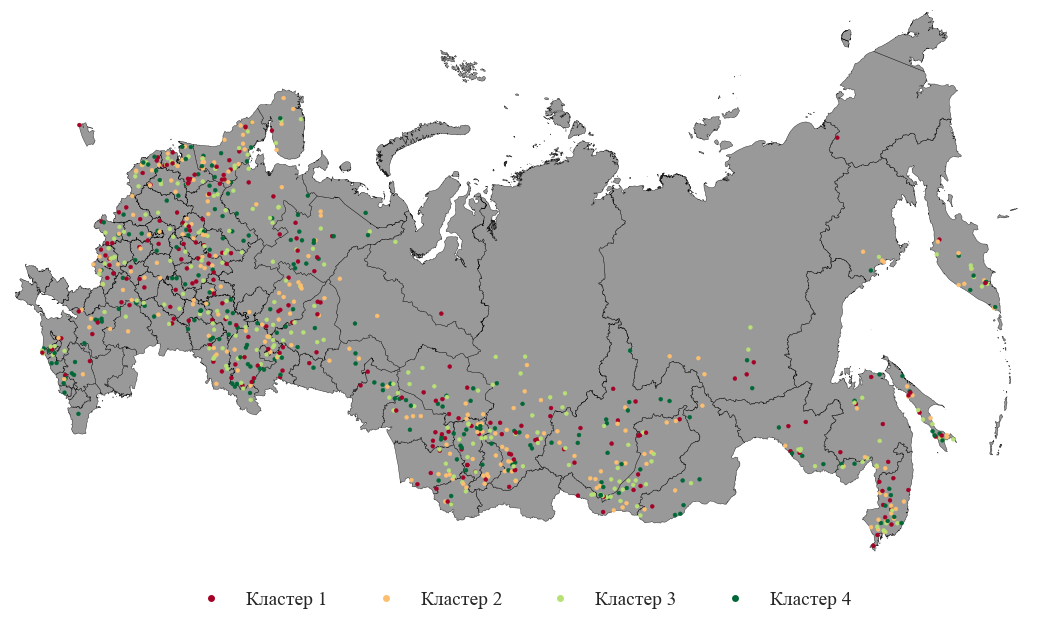

In [211]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA


tft_test_cluster = tft_test_cluster[tft_test_cluster.index.isin(
    tft_era5l.index)]

tft_cluster = deepcopy(tft_era5l)
tft_cluster = tft_cluster[tft_cluster.index.isin(tft_test_cluster.index)]

def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(tft_test_cluster))

tft_cluster['Кластер_tft'] = [str(f'Кластер {i+1}')for i in yhat_AC]
tft_test_cluster['ResClust'] = [i+1 for i in yhat_AC]

gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='Кластер_tft',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)
gauges_fig.savefig('./images/clusters_Rus_tft.png',
                   dpi=650, bbox_inches='tight')

In [215]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

test_static = test_static.loc[tft_era5l.index, :]
def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df


km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(test_static))

tft_era5l['Кластер'] = [str(f'Кластер {i+1}')for i in yhat_AC]
test_static['ResClust'] = [i+1 for i in yhat_AC]

In [38]:
nse_for_clust = pd.DataFrame()
for i, (clust, vals) in enumerate(tft_era5l.groupby('Кластер').groups.items()):
    nse_for_clust.loc[i, 'Кластер'] = clust
    nse_for_clust.loc[i, 'NSE'] = tft_era5l.loc[vals, 'NSE'].median()
    

In [239]:
res_cluster = tft_era5l[['Кластер']]
res_cluster = res_cluster.loc[tft_era5l.index.isin(tft_cluster.index), :]
res_cluster.loc[:, 'Кластер_tft'] = tft_cluster.loc[tft_cluster.index.isin(tft_era5l.index), 'Кластер_tft']
tft_cluster['предсказание кластера'] = ['Удачное' if i else 'Неудачное'
                                        for i in
                                        (res_cluster['Кластер'] == res_cluster['Кластер_tft'])]

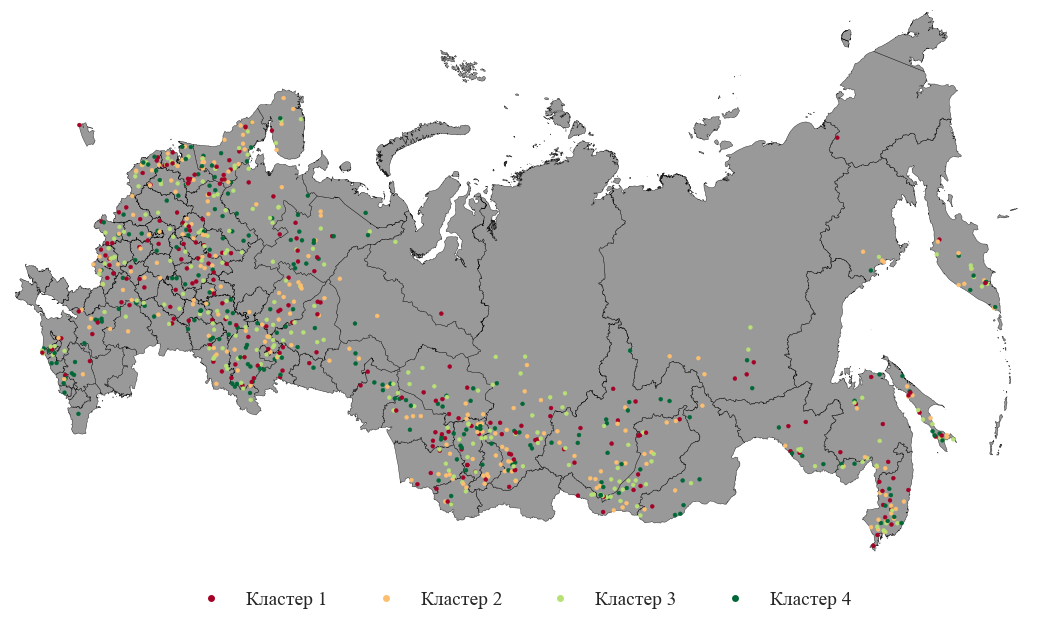

In [244]:
gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='Кластер_tft',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)

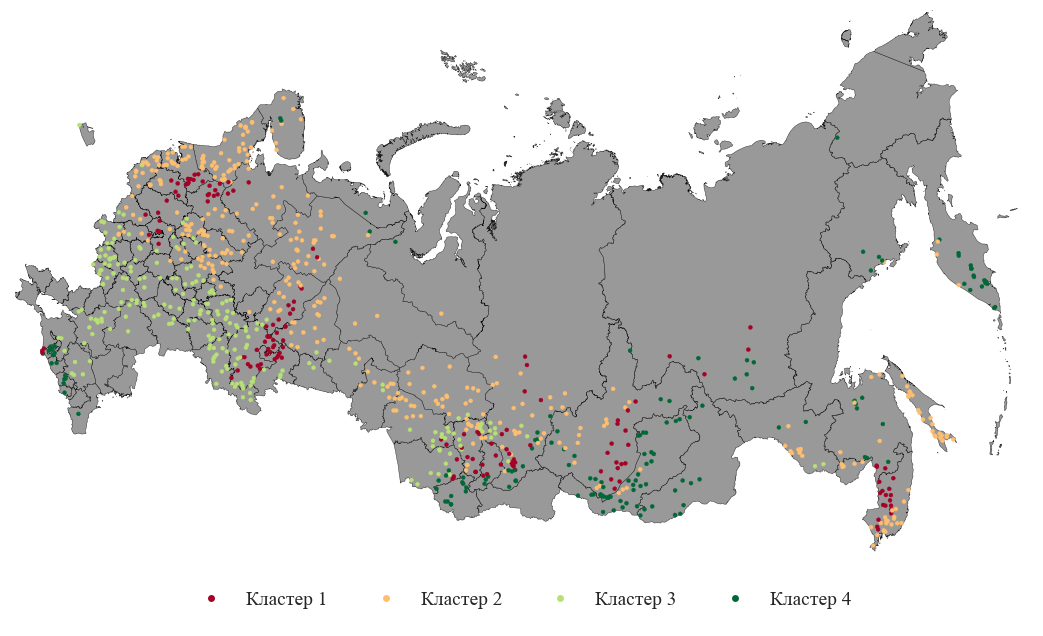

In [245]:
gauges_fig = russia_plots(gdf_to_plot=tft_era5l,
                          basemap_data=basemap_data,
                          distinction_col='Кластер',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1, 2, 3, 4],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)

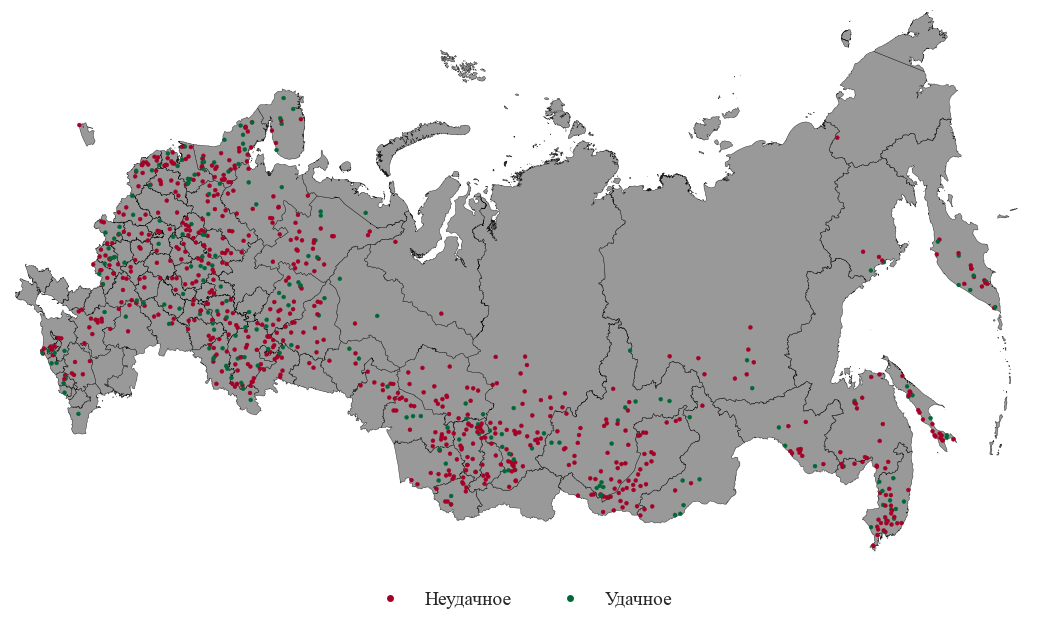

In [243]:
gauges_fig = russia_plots(gdf_to_plot=tft_cluster,
                          basemap_data=basemap_data,
                          distinction_col='предсказание кластера',
                        #   metric_col='Кластер',
                          list_of_limits=[0, 1],
                          figsize=(15, 8),
                          just_points=True,
                          with_histogram=False)
# gauges_fig.savefig('./images/clusters_Rus_tft.png',
                #    dpi=650, bbox_inches='tight')

In [237]:
(res_cluster['Кластер'] == res_cluster['Кластер_tft']).sum()

222

In [227]:
tft_cluster

name_ru                            name_en   
gauge_id                                                                        
49014        р.Корпи-Йоки - пос.Пяозерский     r.Korpi-Joki - pos.Pjaozerskij  \
49047               р.Судно - с.Вокнаволок             r.Sudno - s.Voknavolok   
49052                р.Ухта - пгт Калевала              r.Uhta - pgt Kalevala   
49058            р.Чирко-Кемь - с.Юшкозеро       r.Chirko-Kem' - s.Jushkozero   
49070                  р.Шуя - с.Шуерецкое            r.Shuja - s.Shueretskoe   
...                                    ...                                ...   
5664       р.Левый Ул - пос.Многовершинный   r.Levyj Ul - pos.Mnogovershinnyj   
49053          р.Норви-Йоки - пгт Калевала        r.Norvi-Joki - pgt Kalevala   
2107               р.Половинка - г.Елизово            r.Polovinka - g.Elizovo   
2106      р.Половинка - в 13.7 км от устья  r.Polovinka - v 13.7 km ot ust'ja   
7176               р.Слюдянка - г.Слюдянка        r.Sljudjanka - g.Sljudjanka   

                            geometry       NSE    day      static    encoder   
gauge_id                                                                       
49014      POINT (31.05794 65.77917)  0.949277  294.0  inu_pc_ult   prcp_e5l  \
49047      POINT (30.50502 64.95504)  0.951980    1.0  ele_mt_sav   q_mm_day   
49052      POINT (31.14297 65.21779)  0.732684    1.0  ire_pc_sse   prcp_e5l   
49058      POINT (32.11508 64.75309)  0.975160   74.0  ele_mt_sav   q_mm_day   
49070      POINT (34.71204 64.74240)  0.744663   24.0  lkv_mc_usu   q_mm_day   
...                              ...       ...    ...         ...        ...   
5664      POINT (139.86442 53.61337)  0.843053   62.0  sgr_dk_sav   prcp_e5l   
49053      POINT (31.22690 65.19361)  0.953800  365.0  lkv_mc_usu  t_max_e5l   
2107      POINT (158.36421 53.18661)  0.927761    1.0  lka_pc_use   q_mm_day   
2106      POINT (158.21890 53.16076)  0.838575  202.0  sgr_dk_sav   q_mm_day   
7176      POINT (103.69834 51.64244)  0.193418    1.0  ire_pc_sse   q_mm_day   

            decoder Кластер_tft  
gauge_id                         
49014      prcp_e5l   Кластер 4  
49047      prcp_e5l   Кластер 2  
49052     t_max_e5l   Кластер 1  
49058     t_max_e5l   Кластер 2  
49070     t_max_e5l   Кластер 4  
...             ...         ...  
5664       prcp_e5l   Кластер 1  
49053     t_max_e5l   Кластер 1  
2107      t_min_e5l   Кластер 4  
2106      t_min_e5l   Кластер 1  
7176       prcp_e5l   Кластер 4  

[908 rows x 9 columns]

In [21]:
test_static = test_static.loc[tft_era5l.index, :]
def pca95(df: pd.DataFrame) -> np.ndarray:
    scale_df = MinMaxScaler().fit_transform(df)

    pca_trans = PCA(n_components=0.95, random_state=42)
    pca_trans.fit(scale_df)

    reduced_df = pca_trans.transform(scale_df)

    return reduced_df

test_static.loc[:, :] = MinMaxScaler().fit_transform(test_static.values)
km = KMeans(n_clusters=4, random_state=42, n_init=100)

yhat_AC = km.fit_predict(pca95(test_static))

tft_era5l['Кластер'] = [str(f'Кластер {i+1}')for i in yhat_AC]
test_static['ResClust'] = [i+1 for i in yhat_AC]
# test_static['color'] = test_static['ResClust'].apply(
    # lambda x: dict(zip([1, 2, 3, 4], color_list))[x])

In [33]:
polar = test_static.groupby('ResClust').mean().reset_index()

polar = pd.melt(polar, id_vars=['ResClust'])


fig_polar = px.line_polar(polar, r='value', theta='variable',
                          color='ResClust', color_discrete_sequence=color_list,
                          template='seaborn', height=800, width=800)
fig_polar.update_layout(
    polar=dict(
        # radialaxis_angle = -45
        radialaxis=dict(showticklabels=False, ticks=''),
        angularaxis=dict(showticklabels=True, tickangle=0)
    ),
    legend_title_text='Кластеры',
    legend=dict(
        orientation="h",
        yanchor="middle",
        y=-.1,
        xanchor="center",
        x=0.5,
        bgcolor=None,
        bordercolor="Black",
        borderwidth=0
    )
)
fig_polar.write_image('./images/cluster_importance.png')


In [34]:
fig_polar

### temp

In [ ]:
from forecast.scripts.model_eval import nse
lost_df = pd.DataFrame()
for i, file in enumerate(glob.glob('../forecast/result/lost_gauge/*.csv')):
    gauge_id = file.split('/')[-1][:-4]
    compare_res = pd.read_csv(f'../forecast/result/lost_gauge/{gauge_id}.csv')
    # get nse
    pred_nse = nse(pred=compare_res['q_mm_day_pred'],
                   target=compare_res['q_mm_day'])
    lost_df.loc[i, 'gauge_id'] = gauge_id
    lost_df.loc[i, 'NSE'] = pred_nse
lost_df